# <font color="#114b98">Projet 7 : Développez une preuve de concept</font>

Ce projet vise à explorer et implémenter une nouvelle méthode pour améliorer un algorithme de machine learning actuellement en production. 

Le jeu de données étudié dans ce projet se nomme **UTKFace**, un ensemble de données de visages à grande échelle contenant des images avec des informations d'âge, de genre et d'origine ethnique. Il est disponible au lien suivant : https://susanqq.github.io/UTKFace/.

Ces images offrent une grande variété de caractéristiques faciales, permettant ainsi une meilleure généralisation pour les applications de reconnaissance des émotions et d'autres attributs faciaux dans des situations réelles.

Tout d'abord, nous utiliserons le modèle **MobileNetV3**, qui a été entraîné sur l'ensemble de données **ImageNet** et qui présente l'avantage d'être plus léger et plus rapide que certains modèles très performants comme InceptionV3, pour extraire les caractéristiques des images, et avoir une référence (ou "baseline") pour évaluer les performances de nos modèles ultérieurs.

Cependant, nous rencontrons un problème de déséquilibre des classes pour l'âge et l'origine ethnique. Pour résoudre ce problème, nous allons adopter deux approches différentes.

Dans un premier temps, nous allons tester des méthodes usuelles, telles que la pondération des classes ou l'utilisation de techniques de sous-échantillonnage, pour équilibrer les classes. Ces méthodes sont couramment utilisées dans les cas de déséquilibre de classes pour améliorer les performances des modèles.

Dans un second temps, nous allons implémenter des méthodes State-of-the-Art (SOTA) pour résoudre spécifiquement le problème de déséquilibre des classes. Pour l'âge, nous utiliserons la méthode **DenseWeight** (Steininger, M., Kobs, K., Davidson, P. et al. Density-based weighting for imbalanced regression. Mach Learn 110, 2187–2211 (2021). https://doi.org/10.1007/s10994-021-06023-5) qui pondère les erreurs de manière à accorder plus d'importance aux groupes sous-représentés. Pour l'origine ethnique, nous utiliserons la fonction de perte **LMFLoss** (Abu Adnan Sadi, Labib Chowdhury, Nursrat Jahan, Mohammad Newaz Sharif Rafi, Radeya Chowdhury, Faisal Ahamed Khan, Nabeel Mohammed. LMFLOSS: A Hybrid Loss For Imbalanced Medical Image Classification. arXiv preprint arXiv:2212.12741 (2022). https://arxiv.org/pdf/2212.12741.pdf), qui vise à réduire le déséquilibre de la distribution de la classe majoritaire tout en dirigeant l'attention du modèle vers les classes minoritaires.

Nous allons ensuite construire notre propre modèle pour prédire **l'âge, le genre et l'origine ethnique simultanément**. Nous allons entraîner et évaluer ce modèle sur l'ensemble de données UTKFace, en utilisant des métriques appropriées pour chaque tâche. Nous comparerons également les performances de notre modèle à celles du modèle MobileNet, afin de déterminer s'il est capable d'améliorer les performances de la référence.

Enfin, nous effectuerons une analyse approfondie de notre modèle pour comprendre ses forces et ses faiblesses, et pour proposer des pistes d'amélioration pour de futures recherches dans ce domaine.

## <font color="#114b98">Sommaire</font>
[1. Chargement du jeu de données](#section_1)

[2. Exploration du jeu de données](#section_2)

[3. Préparation des données](#section_3)

[4. Modèle MobileNetV3Small - Baseline](#section_4)

[5. Pondération des échantillons lors de l'entraînement](#section_5)

[6. Sous-échantillonage de la classe majoritaire](#section_6)

[7. Implémentation de DenseWeight & LMFLoss](#section_7)

[8. Comparaison des performances](#section_8)

## <font color="#114b98" id="section_1">1. Chargement du jeu de données</font>

In [1]:
import os
import re
import cv2
import sys
import pickle
import sklearn
import warnings
import visualkeras
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing
import tensorflow as tf
import keras.backend as K
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image, ImageFont
from keras.optimizers import Adam
from keras_tuner import Objective
import plotly.graph_objects as go
import matplotlib.ticker as ticker
from collections import defaultdict
import matplotlib.colors as mcolors
from denseweight import DenseWeight
from plotly.subplots import make_subplots
from keras.callbacks import EarlyStopping
from keras.models import Sequential, load_model
from keras.applications import MobileNetV3Small
from keras import Model, mixed_precision, losses
from keras_tuner.tuners import BayesianOptimization
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Rescaling
from keras.layers import BatchNormalization, MaxPooling2D, Flatten, ZeroPadding2D, Conv2D
from sklearn.metrics import classification_report, confusion_matrix, f1_score, mean_absolute_error

In [2]:
print("System Version: ", sys.version)
print("Scikit-learn Version: ", sklearn.__version__)
print("Tensorflow Version: ", tf.__version__)
print("Keras Version: ", tf.keras.__version__)
print("Num CPUs Available: ", multiprocessing.cpu_count())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Tensorflow build with CUDA:", tf.test.is_built_with_cuda())

# Increase GPU capacity
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_global_policy(policy)

System Version:  3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
Scikit-learn Version:  1.2.2
Tensorflow Version:  2.10.1
Keras Version:  2.10.0
Num CPUs Available:  16
Num GPUs Available:  1
Tensorflow build with CUDA: True
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


In [3]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
sns.set_style('whitegrid')
tf.autograph.set_verbosity(0)
tf.config.run_functions_eagerly(True)
tf.get_logger().setLevel('ERROR')
font = ImageFont.truetype("arial.ttf", 20) 
gender_palette = {0: '#4166F5', 1: 'hotpink'}
ethnicity_palette = sns.hls_palette()
palette = sns.color_palette("Set2", n_colors=11)
colors = [mcolors.to_hex(mcolors.to_rgba(color)) for color in palette]
color_map = defaultdict(dict)
color_map[ZeroPadding2D]['fill'] = colors[0]
color_map[Rescaling]['fill'] = colors[1]
color_map[MaxPooling2D]['fill'] = colors[3]
color_map[Conv2D]['fill'] = colors[4]
color_map[Dense]['fill'] = colors[6]
color_map[Flatten]['fill'] = colors[5]
color_map[BatchNormalization]['fill'] = colors[7]
color_map[GlobalAveragePooling2D]['fill'] = colors[8]
color_map[Sequential]['fill'] = colors[9]
color_map[Dropout]['fill'] = colors[10]
# %load_ext pycodestyle_magic
# %pycodestyle_on

In [4]:
# Répertoire de travail
path = 'N:/5 - WORK/1 - Projets/Projet 7/ressources/UTKFace/'
dataset_dir = path + 'cropped'

# Definition de la taille des batchs et des images
batch_size = 64
image_size = (224, 224)
input_shape = (224, 224, 3)

# Fonction pour le pre-processing des images
def preprocess_image(row):
    image_path = row['image_path']
    image = Image.open(image_path)
    return np.array(image) / 255.0

# Définition des dictionnaires de résultats
dict_age_mae = dict()
dict_gender_accuracy = dict()
dict_ethnicity_f1_macro = dict()

# Fonction de chargement du dataset
def load_dataset(dataset_dir):
    file_list = os.listdir(dataset_dir)
    data = [{'age': int(matches[1]),
             'gender': int(matches[2]),
             'ethnicity': int(matches[3]),
             'image_path': os.path.join(dataset_dir, file)} 
            for file in file_list
            if file.endswith('.jpg.chip.jpg') or file.endswith('.jpg')
            if (matches := re.match(r'(\d+)_(\d)_(\d)_', file))]
    df = pd.DataFrame(data)
    return df.rename(columns={'race': 'ethnicity'})

# Chargement du dataset
df = load_dataset(dataset_dir)
df.head()

age  gender  ethnicity                                         image_path
0  100       0          0  N:/5 - WORK/1 - Projets/Projet 7/ressources/UT...
1  100       0          0  N:/5 - WORK/1 - Projets/Projet 7/ressources/UT...
2  100       1          0  N:/5 - WORK/1 - Projets/Projet 7/ressources/UT...
3  100       1          0  N:/5 - WORK/1 - Projets/Projet 7/ressources/UT...
4  100       1          0  N:/5 - WORK/1 - Projets/Projet 7/ressources/UT...

Les étiquettes de chaque image de visage sont intégrées dans le nom du fichier, formatées comme [âge][sexe][race]_[date&heure].jpg

 - [âge] est un entier de 0 à 116, indiquant l'âge
 - [sexe] est soit 0 (Male) ou 1 (Female)
 - [race] est un entier de 0 à 4, indiquant White, Black, Asian, Indian et Other (comme Hispanique, Latino, Moyen-Orient).

## <font color="#114b98" id="section_2">2. Exploration du jeu de données</font>

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23690 entries, 0 to 23689
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   age         23690 non-null  int64 
 1   gender      23690 non-null  int64 
 2   ethnicity   23690 non-null  int64 
 3   image_path  23690 non-null  object
dtypes: int64(3), object(1)
memory usage: 740.4+ KB


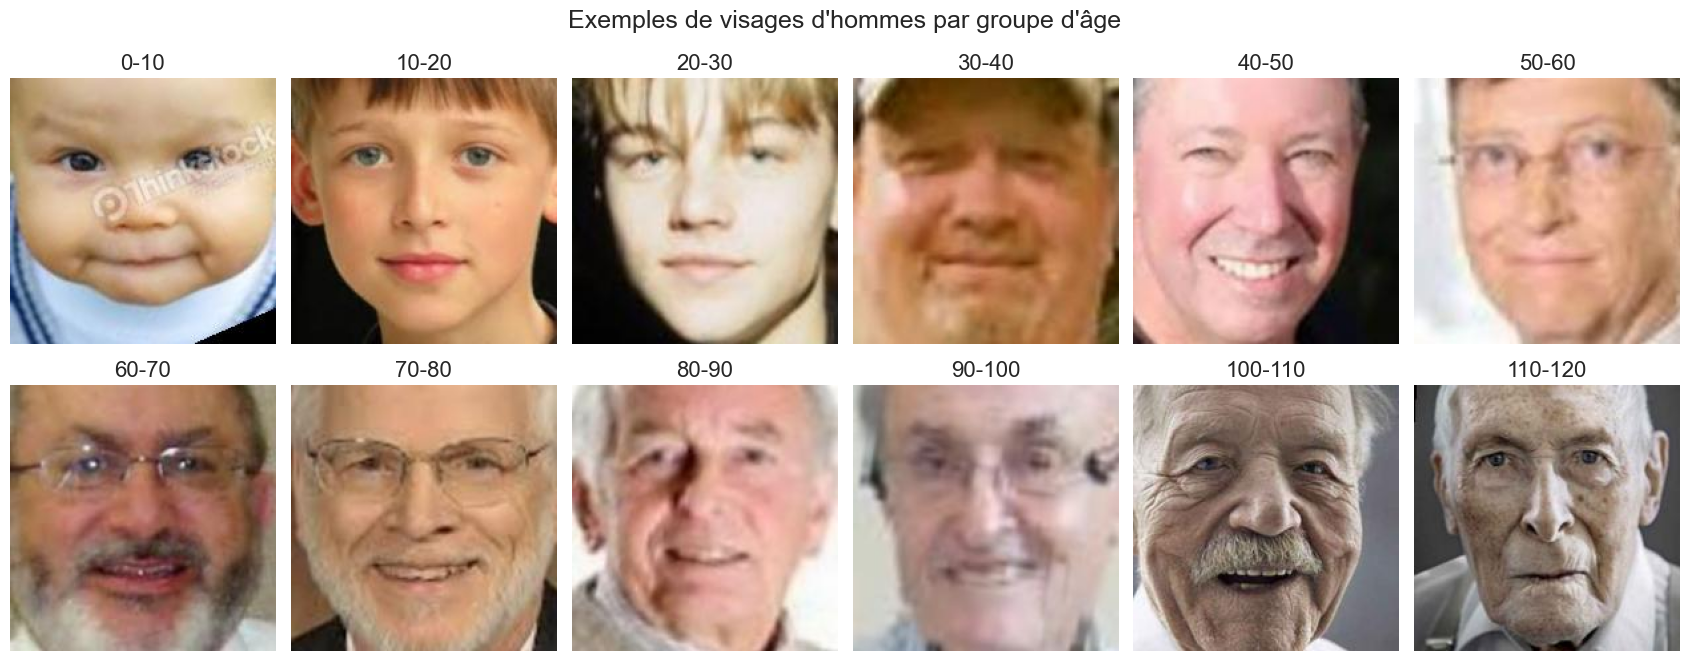

In [6]:
# Définition des groupes d'âge
age_bins = [(i, i+10) for i in range(0, 120, 10) if i < 120]

# Créer un dictionnaire pour stocker un exemple de visage pour chaque tranche d'âge
example_faces = {i: None for i in range(len(age_bins))}

# Parcourir l'ensemble de données et trouver la première image d'homme pour chaque tranche d'âge
for _, row in df.iterrows():
    age = row['age']
    gender = row['gender']
    if gender == 0: 
        for i, age_bin in enumerate(age_bins):
            if age >= age_bin[0] and age < age_bin[1]:
                if example_faces[i] is None:
                    example_faces[i] = preprocess_image(row)
                break

fig, axes = plt.subplots(2, 6, figsize=(17, 7))
for i, ax in enumerate(axes.flatten()):
    if example_faces[i] is not None:
        face = example_faces[i]
        face = (face * 255).astype('uint8')
        ax.imshow(face)
        ax.set_title(f'{age_bins[i][0]}-{age_bins[i][1]}', size=16)
        ax.axis('off')
        
plt.suptitle("Exemples de visages d'hommes par groupe d'âge", fontsize=18)
plt.tight_layout()
plt.show()

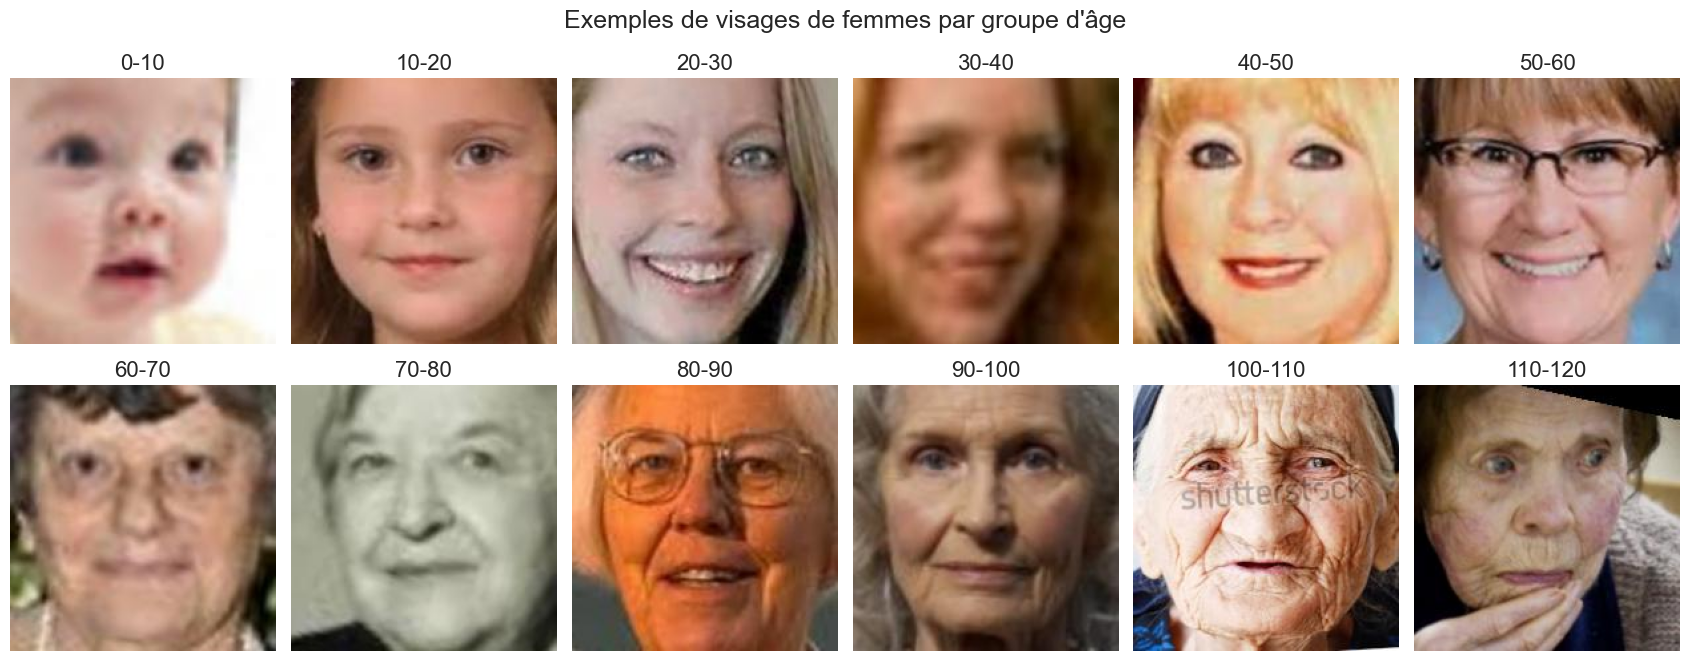

In [7]:
# Créer un dictionnaire pour stocker un exemple de visage pour chaque tranche d'âge
example_faces = {i: None for i in range(len(age_bins))}

# Parcourir l'ensemble de données et trouver la première image de femme pour chaque tranche d'âge
for _, row in df.iterrows():
    age = row['age']
    gender = row['gender']
    if gender == 1: 
        for i, age_bin in enumerate(age_bins):
            if age >= age_bin[0] and age < age_bin[1]:
                if example_faces[i] is None:
                    example_faces[i] = preprocess_image(row)
                break

fig, axes = plt.subplots(2, 6, figsize=(17, 7))
for i, ax in enumerate(axes.flatten()):
    if example_faces[i] is not None:
        face = example_faces[i]
        face = (face * 255).astype('uint8')
        ax.imshow(face)
        ax.set_title(f'{age_bins[i][0]}-{age_bins[i][1]}', size=16)
        ax.axis('off')

plt.suptitle('Exemples de visages de femmes par groupe d\'âge', fontsize=18)
plt.tight_layout()
plt.show()

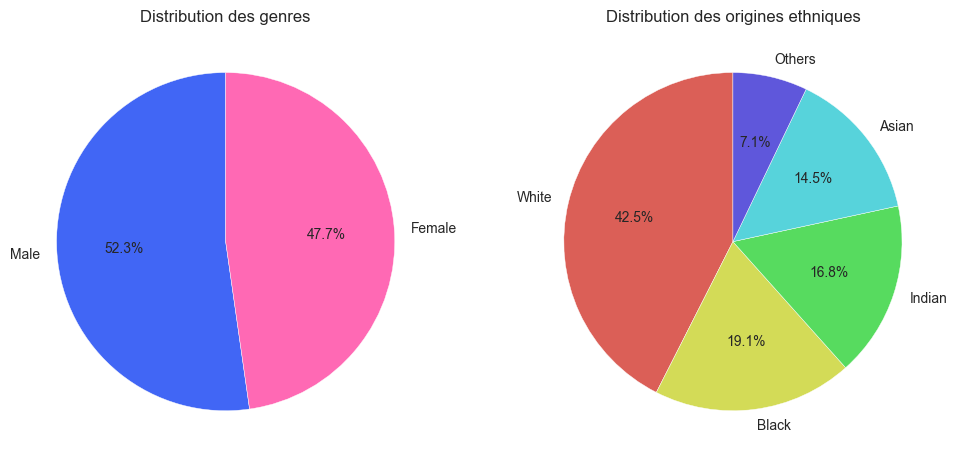

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Distribution des genres
gender_counts = df['gender'].value_counts().rename({0: 'Male', 1: 'Female'})
gender_colors = [gender_palette[gender] for gender in sorted(gender_palette.keys())]
gender_counts.plot.pie(ax=ax1, autopct='%1.1f%%', startangle=90, colors=gender_colors)
ax1.set_title("Distribution des genres")
ax1.set_ylabel("")

# Distribution des origines ethniques
ethnicity_counts = df['ethnicity'].value_counts().rename({
    0: 'White',
    1: 'Black',
    2: 'Asian',
    3: 'Indian',
    4: 'Others'
})
ethnicity_counts.plot.pie(ax=ax2, autopct='%1.1f%%', startangle=90, colors=ethnicity_palette)
ax2.set_title("Distribution des origines ethniques")
ax2.set_ylabel("")

plt.show()

La classe Other rassemble diverses origines ethniques (Hispanique, Latino, Moyen-Orient) qui partagent peu de similitudes. Les expérimentations menées antérieurement dans ce projet ont révélé que cette catégorie est plutôt difficile à classifier, même en utilisant des méthodes récentes et avancées, en raison de la grande diversité des sous-groupes présents. Je décide donc de supprimer cette classe du dataset.

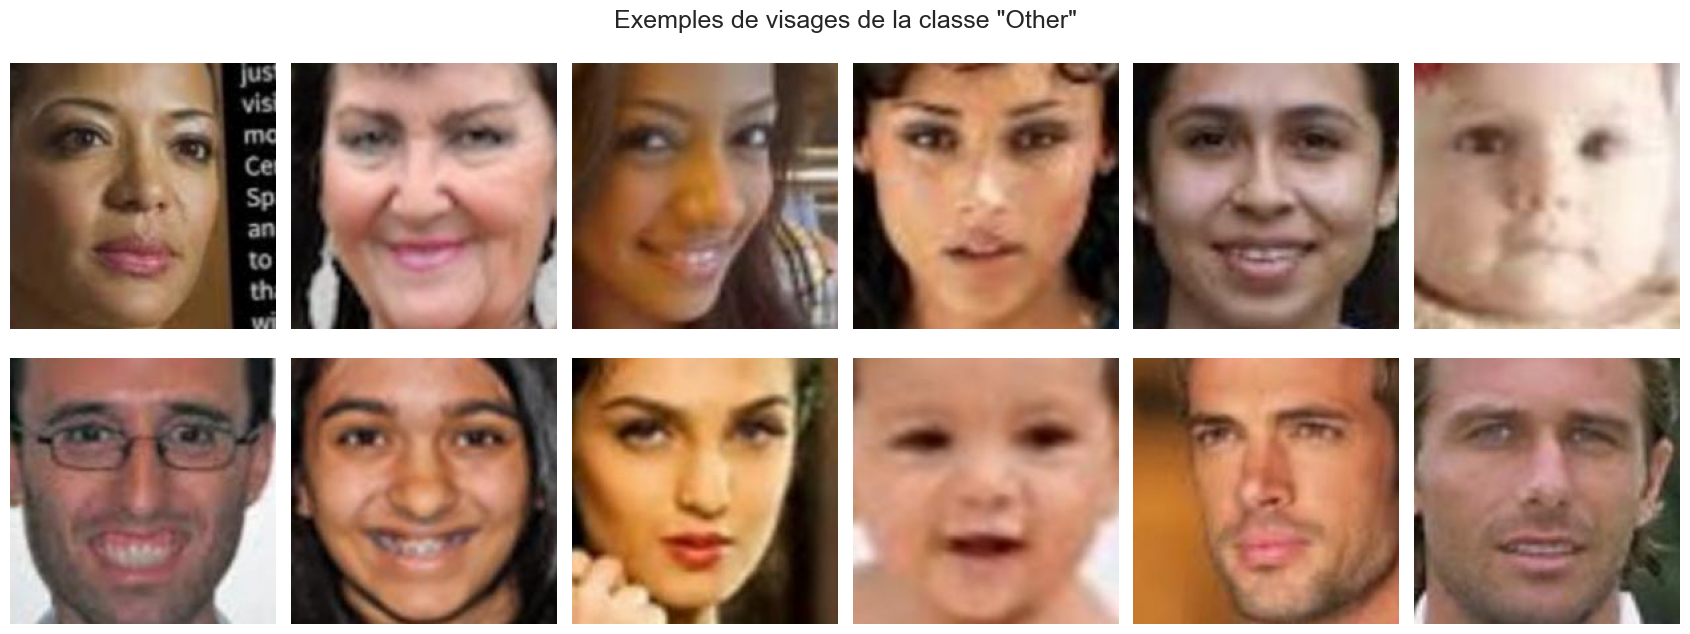

In [9]:
# Créer un dictionnaire pour stocker les exemples de visages
example_faces = []
dfs = df.sample(frac=1, random_state=42)

# Parcourir l'ensemble de données et trouver des images de personnes appartenant à la classe Other
for _, row in dfs.iterrows():
    eth = row['ethnicity']
    if eth == 4: 
        example_faces.append(preprocess_image(row))
        if len(example_faces) >= 12:
            break
            
fig, axes = plt.subplots(2, 6, figsize=(17, 7))
for i, ax in enumerate(axes.flatten()):
    if example_faces[i] is not None:
        face = example_faces[i]
        face = (face * 255).astype('uint8')
        ax.imshow(face)
        ax.axis('off')

plt.suptitle('Exemples de visages de la classe "Other"', fontsize=18, y=0.95)
plt.tight_layout()
plt.show()

In [10]:
# Suppession des observations où l'origine ethnique est égale à 4 (Others)
df = df[df['ethnicity'] != 4]
classes_eth = df['ethnicity'].nunique()

In [11]:
# Je cherche maintenant à savoir le nombre de personnes dont l'âge dépasse ou est égal à 90 ans.
above_90 = df[df['age'] >= 90].groupby('ethnicity').size()
print(above_90)

ethnicity
0    110
1     17
2     36
3      5
dtype: int64


In [12]:
# Je cherche maintenant à savoir le nombre de personnes dont l'âge dépasse ou est égal à 80 ans.
above_80 = df[df['age'] >= 80].groupby('ethnicity').size()
print(above_80)

ethnicity
0    482
1     58
2    100
3     26
dtype: int64


Il y a très peu de personnes dont l'âge dépasse 80 ans, en particulier pour les classes 1 et 3. Afin d'assurer la présence de valeurs correspondant à ces âges et ces origines ethniques dans les différents ensembles de données, je décide de conserver uniquement les photos des personnes dont l'âge est inférieur à 80 ans.

In [13]:
df = df[df['age'] < 80]

Je souhaite maintenant créer un ensemble de test personnalisé avant d'appliquer le sous-échantillonnage.

In [14]:
# Création des tranches d'âge de 10 ans
age_bins_range = range(0, df['age'].max() + 10, 10)
df['age_group'] = pd.cut(df['age'], bins=age_bins_range, labels=False, right=False)

# Sélection de 10 photos par genre, par origine ethnique, par tranches d'age de 10 ans.
def get_balanced_test_samples(df, n_samples=10):
    test_samples = []
    for age_group in df['age_group'].unique():
        for gender in df['gender'].unique():
            for ethnicity in df['ethnicity'].unique():
                subset = df[(df['age_group'] == age_group) & (df['gender'] == gender) & (df['ethnicity'] == ethnicity)]
                if not subset.empty:
                    samples = subset.sample(n_samples, replace=True)
                    test_samples.append(samples)
    return pd.concat(test_samples)

# Création des dataset de test et d'entrâinement / validation
test_df = get_balanced_test_samples(df)
train_val_df = df[~df.index.isin(test_df.index)]

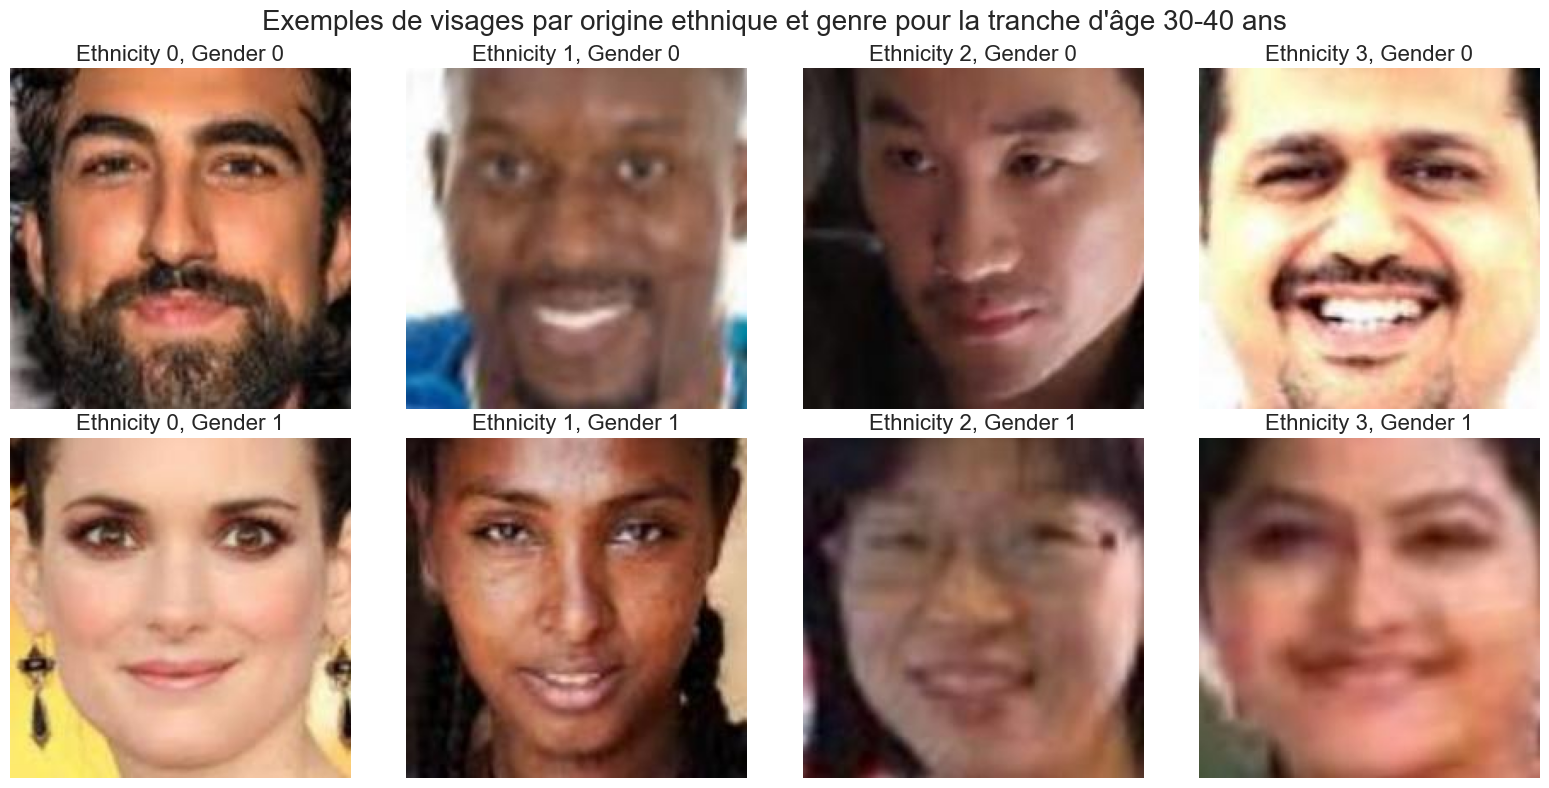

In [15]:
example_faces = {(ethnicity, gender): None for ethnicity in test_df['ethnicity'].unique() for gender in test_df['gender'].unique()}

age_bin = (30, 40)
for _, row in test_df.iterrows():
    age = row['age']
    gender = row['gender']
    ethnicity = row['ethnicity']
    if age >= age_bin[0] and age < age_bin[1]:
        if example_faces[(ethnicity, gender)] is None:
            example_faces[(ethnicity, gender)] = preprocess_image(row)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

ax_idx = 0
for gender in test_df['gender'].unique():
    for ethnicity in test_df['ethnicity'].unique():
        face = example_faces[(ethnicity, gender)]
        if face is not None:
            face = (face * 255).astype('uint8')
            i, j = ax_idx // 4, ax_idx % 4
            axes[i, j].imshow(face)
            axes[i, j].set_title(f'Ethnicity {ethnicity}, Gender {gender}', size=16)
            axes[i, j].axis('off')
            ax_idx += 1

plt.suptitle('Exemples de visages par origine ethnique et genre pour la tranche d\'âge 30-40 ans', fontsize=20)
plt.tight_layout()
plt.show()

Je vais effectuer un sous-échantillonnage sur la classe d'origine ethnique "Asian" (ethnicity = 2) en utilisant la bibliothèque imbalanced-learn de sklearn. Le sous-échantillonnage est réalisé en supprimant 75% des observations de cette classe, ne gardant ainsi qu'1/4 des observations initiales. 

In [16]:
# Définition de la stratégie d'échantillonnage pour la classe Indien
sampling_strategy = {2: int(np.sum(train_val_df['ethnicity'] == 2) / 4)}

# Initialisation du RandomUnderSampler avec la stratégie d'échantillonnage définie
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)

# Ajustement de l'échantillonneur et rééchantillonnement des données
X = train_val_df.drop(columns=['ethnicity'])
y = train_val_df['ethnicity']
X_resampled, y_resampled = rus.fit_resample(X, y)

# Création du DataFrame avec les données rééchantillonnées
train_val_df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

# Réinitialiser l'index du DataFrame
train_val_df_resampled = train_val_df_resampled.reset_index(drop=True)

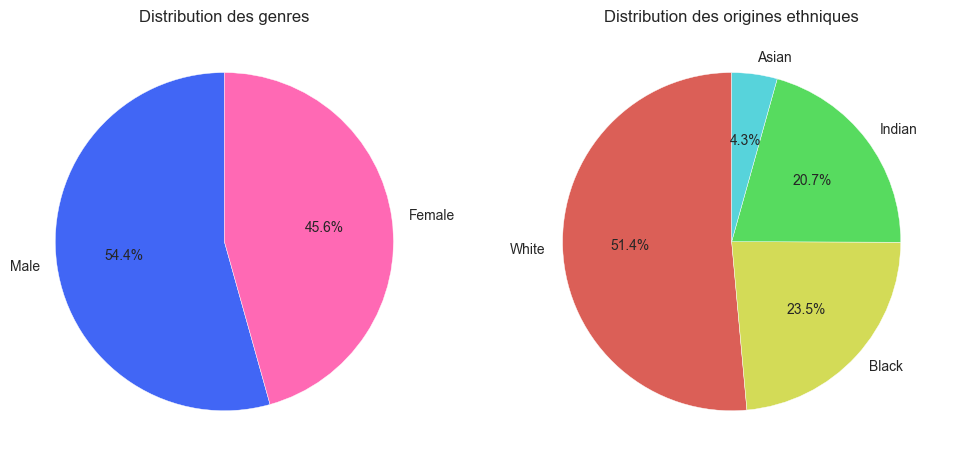

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Distribution des genres
gender_counts = train_val_df_resampled['gender'].value_counts().rename({0: 'Male', 1: 'Female'})
gender_colors = [gender_palette[gender] for gender in sorted(gender_palette.keys())]
gender_counts.plot.pie(ax=ax1, autopct='%1.1f%%', startangle=90, colors=gender_colors)
ax1.set_title("Distribution des genres")
ax1.set_ylabel("")

# Distribution des origines ethniques
ethnicity_counts = train_val_df_resampled['ethnicity'].value_counts().rename({
    0: 'White',
    1: 'Black',
    2: 'Asian',
    3: 'Indian',
})
ethnicity_counts.plot.pie(ax=ax2, autopct='%1.1f%%', startangle=90, colors=ethnicity_palette)
ax2.set_title("Distribution des origines ethniques")
ax2.set_ylabel("")

plt.show()

Nous avons ainsi créé le déséquilibre de ce dataset sur une classe.

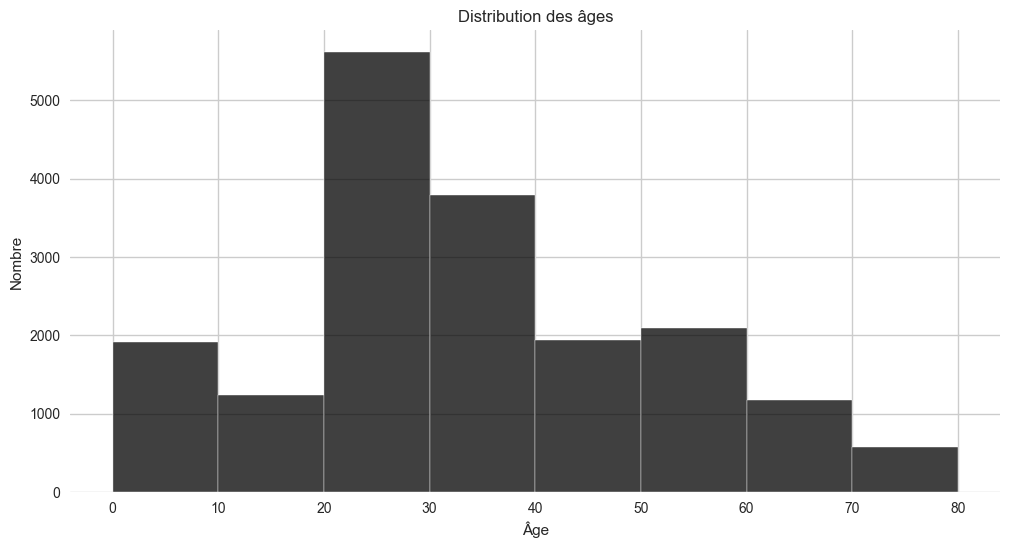

In [18]:
# Distribution des âges
age_bins = [(i, i+10) for i in range(0, 80, 10) if i < 80]
plt.figure(figsize=(12, 6))
bin_edges = [age_bin[0] for age_bin in age_bins] + [age_bins[-1][-1]]
sns.histplot(train_val_df_resampled['age'], bins=bin_edges, color='black')
plt.title("Distribution des âges")
plt.xticks(np.arange(0, 81, 10))
plt.xlabel("Âge")
plt.ylabel("Nombre")
plt.show()

Comparativement aux jeunes, il est plus difficile d'estimer l'âge des personnes âgées ; il est plus facile de distinguer un enfant de 5 ans d'un enfant de 10 ans que de distinguer une personne de 65 ans d'une personne de 70 ans. 

Ainsi, pour l'estimation d'âge relative d'une personne âgée, il est plus efficace d'utiliser une fenêtre de recherche plus grande.

Le processus est modifié en remplaçant chaque âge θ par l'âge logarithmique log θ.

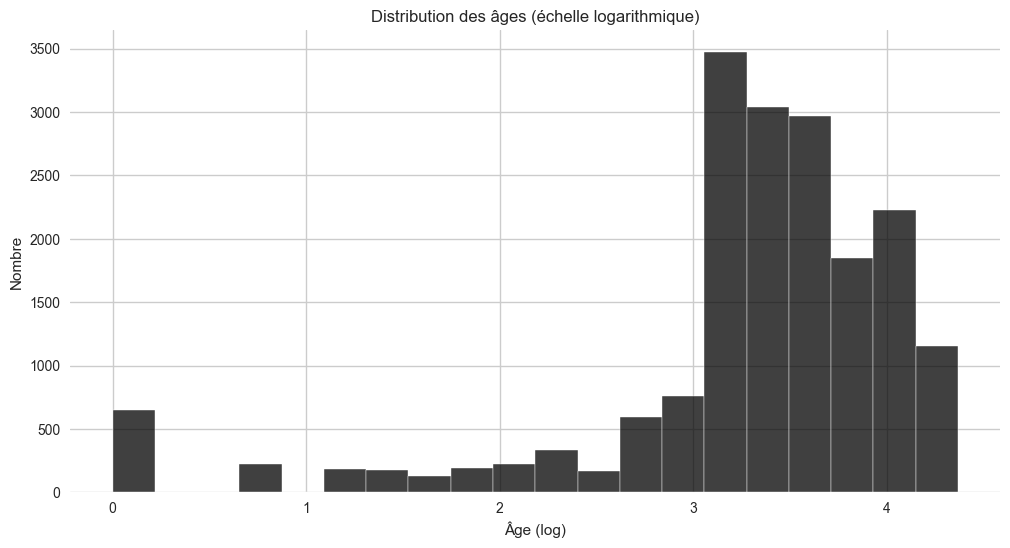

In [19]:
# Créer une nouvelle colonne avec les données d'âge transformées par le logarithme
train_val_df_resampled['log_age'] = np.log(train_val_df_resampled['age'])
test_df['log_age'] = np.log(test_df['age'])

# Tracer l'histogramme des données d'âge transformées
plt.figure(figsize=(12, 6))
sns.histplot(train_val_df_resampled['log_age'], bins=20, color='black')
plt.title("Distribution des âges (échelle logarithmique)")
plt.xlabel("Âge (log)")
plt.ylabel("Nombre")
plt.show()

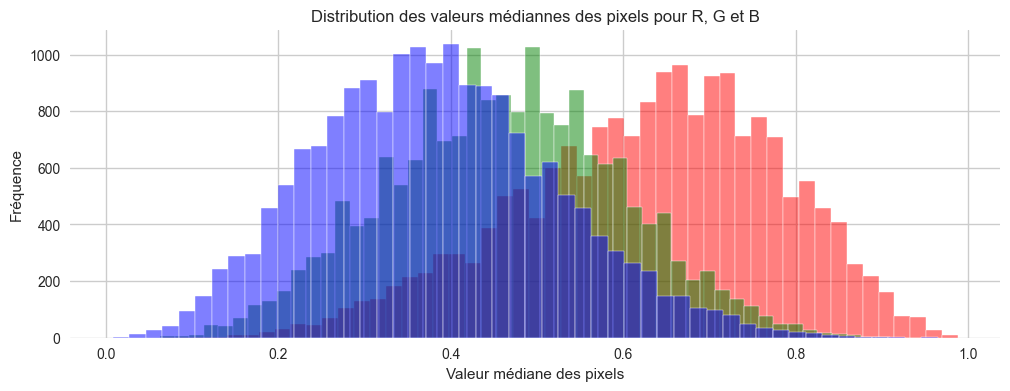

In [20]:
# Calculer les valeurs RGB médianes
medians_r = []
medians_g = []
medians_b = []
for _, row in train_val_df_resampled.iterrows():
    image = preprocess_image(row)
    medians_r.append(np.median(image[:, :, 0]))
    medians_g.append(np.median(image[:, :, 1]))
    medians_b.append(np.median(image[:, :, 2]))

# Tracer les histogrammes en utilisant Seaborn
fig, ax = plt.subplots(figsize=(12, 4))
sns.histplot(data=medians_r, bins=50, kde=False, alpha=0.5, color='red')
sns.histplot(data=medians_g, bins=50, kde=False, alpha=0.5, color='green')
sns.histplot(data=medians_b, bins=50, kde=False, alpha=0.5, color='blue')
ax.set_xlabel('Valeur médiane des pixels')
ax.set_ylabel('Fréquence')
ax.set_title('Distribution des valeurs médiannes des pixels pour R, G et B')
plt.show()

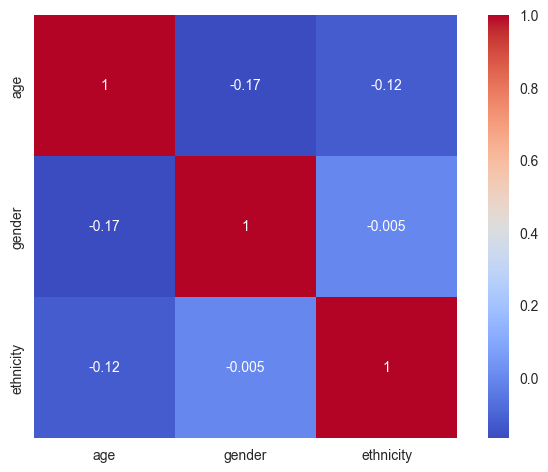

In [21]:
# Calculer la matrice de corrélation
corr_matrix = train_val_df_resampled[['age', 'gender', 'ethnicity']].corr()

# Créer une heatmap de la matrice de corrélation
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.show()

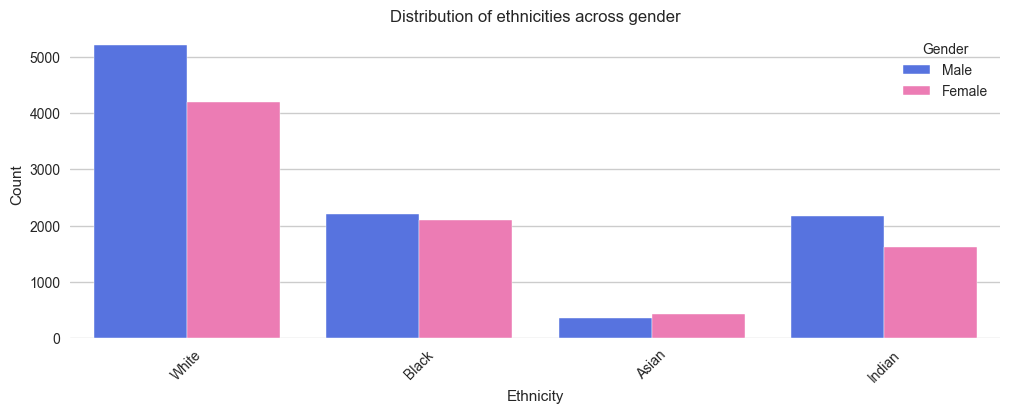

In [22]:
# Définition du dictionnaire des origines ethniques
ethnicity_mapping = {
    0: 'White',
    1: 'Black',
    2: 'Asian',
    3: 'Indian',
}

# Définition du dictionnaire des genres
gender_mapping = {
    0: 'Male',
    1: 'Female'
}

# Adjust the palette to match 'Male' and 'Female'
gender_palette = {
    'Male': gender_palette[0],
    'Female': gender_palette[1]
}

# Distribution des origines ethniques en fonction du genre
ethnicity_gender_counts = train_val_df_resampled.pivot_table(index='ethnicity', columns='gender', values='image_path', aggfunc='count')
ethnicity_gender_counts = ethnicity_gender_counts.fillna(0)
ethnicity_gender_counts = ethnicity_gender_counts.reset_index()
ethnicity_gender_melted = pd.melt(ethnicity_gender_counts, id_vars='ethnicity', var_name='gender', value_name='count')
ethnicity_gender_melted['gender'] = ethnicity_gender_melted['gender'].map(gender_mapping)

plt.figure(figsize=(12, 4))
sns.barplot(data=ethnicity_gender_melted, x='ethnicity', y='count', hue='gender', palette=gender_palette)
plt.title('Distribution of ethnicities across gender')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.xticks(plt.gca().get_xticks(), [ethnicity_mapping[tick] for tick in plt.gca().get_xticks()])
plt.legend(title='Gender')
plt.xticks(rotation=45)
plt.show()

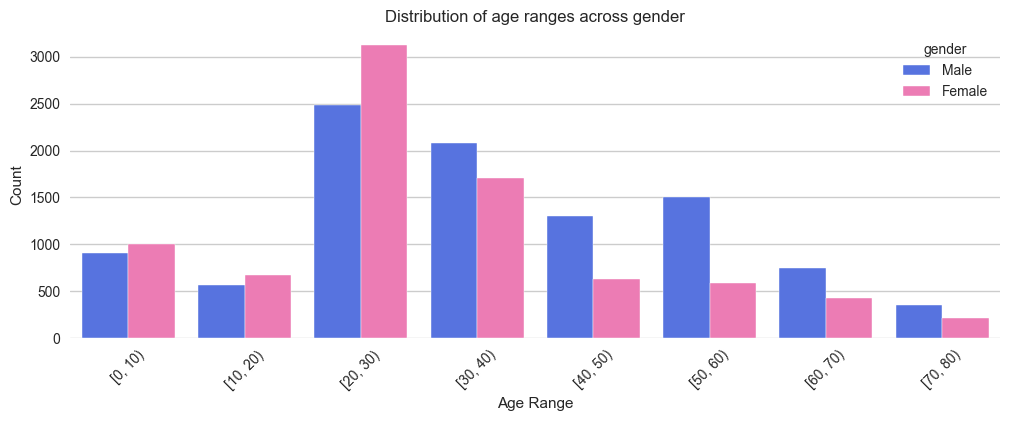

In [23]:
# Distribution des ages en fonction du genre
train_val_df_resampled['age_range'] = pd.cut(train_val_df_resampled['age'], bins=range(0, 90, 10), include_lowest=True, right=False)
age_gender_counts = train_val_df_resampled.pivot_table(index='age_range', columns='gender', values='image_path', aggfunc='count')
age_gender_counts = age_gender_counts.fillna(0)
age_gender_counts = age_gender_counts.reset_index()
age_gender_melted = pd.melt(age_gender_counts, id_vars='age_range', var_name='gender', value_name='count')
age_gender_melted['gender'] = age_gender_melted['gender'].map(gender_mapping)

plt.figure(figsize=(12, 4))
sns.barplot(data=age_gender_melted, x='age_range', y='count', hue='gender', palette=gender_palette)
plt.title('Distribution of age ranges across gender')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

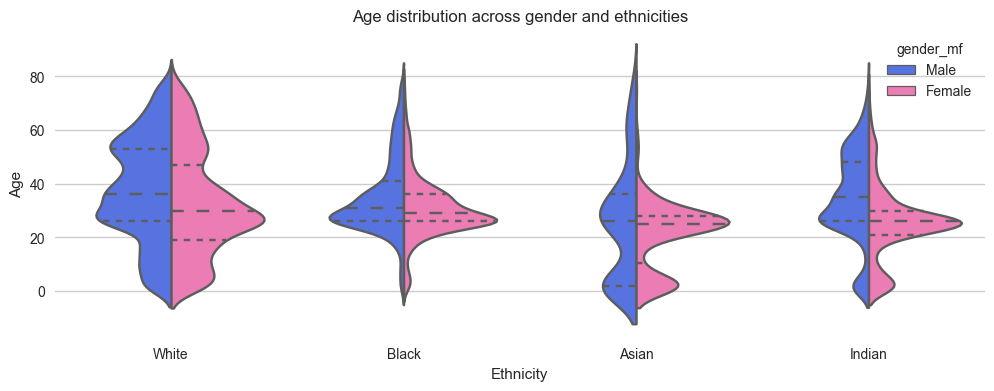

In [24]:
train_val_df_resampled['gender_mf'] = train_val_df_resampled['gender'].map(gender_mapping)

# Distribution des ages en fonction du genre et des origines ethniques
fig, ax = plt.subplots(figsize=(12, 4))
sns.violinplot(x='ethnicity', y='age', hue='gender_mf', data=train_val_df_resampled, split=True,
               inner='quartile', ax=ax, palette=gender_palette)
plt.title('Age distribution across gender and ethnicities')
plt.xlabel('Ethnicity')
plt.ylabel('Age')
ax = plt.gca()
ax.set_xticklabels([ethnicity_mapping[tick] for tick in ax.get_xticks()])
plt.show()

## <font color="#114b98" id="section_3">3. Préparation des données</font>

In [25]:
# Division du DataFrame en un ensemble d'entraînement (80 %) et un ensemble de validation (20 %)
train_df, val_df = train_test_split(train_val_df_resampled, test_size=0.2, random_state=42)

# Définition des générateurs
train_datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col=['log_age', 'gender', 'ethnicity'],
    target_size=image_size,
    batch_size=batch_size,
    class_mode='multi_output',
    color_mode="rgb",
    shuffle=True,
    seed=42,
)

val_generator = ImageDataGenerator().flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col=['log_age', 'gender', 'ethnicity'],
    target_size=image_size,
    batch_size=batch_size,
    class_mode='multi_output',
    color_mode="rgb",
    shuffle=True,
    seed=42,
)

test_generator = ImageDataGenerator().flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col=['log_age', 'gender', 'ethnicity'],
    target_size=image_size,
    batch_size=batch_size,
    class_mode='multi_output',
    color_mode="rgb",
    shuffle=True,
    seed=42,
)

Found 14667 validated image filenames.
Found 3667 validated image filenames.
Found 640 validated image filenames.


J'ai moins d'images qu'usuellement dans mon dataset de test mais celles-ci sont bien équilibrées.

In [26]:
total_samples = train_generator.n
image_shape = train_generator.image_shape
batch_size = train_generator.batch_size
number_of_batches = len(train_generator)
images, labels = next(train_generator)

print("Total samples:", total_samples)
print("Image shape:", image_shape)
print("Batch size:", batch_size)
print("Number of batches:", number_of_batches)
print("Min pixel value:", np.min(images))
print("Max pixel value:", np.max(images))

Total samples: 14667
Image shape: (224, 224, 3)
Batch size: 64
Number of batches: 230
Min pixel value: 0.0
Max pixel value: 255.0


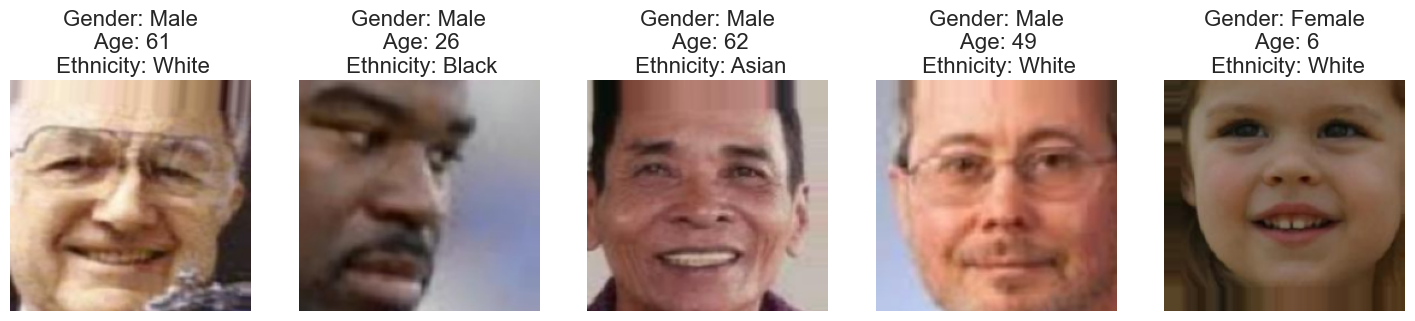

In [27]:
# Obtenir un lot d'images depuis le générateur d'entraînement
images, labels = next(train_generator)

# Définition d'une fonction pour décoder les étiquettes 
def decode_labels(log_age, gender, ethnicity):
    gender_str = "Male" if gender == 0 else "Female"
    ethnicity_str = ethnicity_mapping[ethnicity]
    age_str = int(np.exp(log_age))
    return f"Gender: {gender_str}\n Age: {age_str}\n Ethnicity: {ethnicity_str}"

# Obtenir les cinq premières images du lot
fig, axes = plt.subplots(1, 5, figsize=(18, 3))
for i in range(5):
    log_age, gender, ethnicity = labels[0][i], labels[1][i], labels[2][i]
    title = decode_labels(log_age, gender, ethnicity)
    resized_image = cv2.resize(((images[i])).astype('uint8'), (200, 200), interpolation=cv2.INTER_AREA)
    axes[i].imshow(resized_image, aspect='auto')
    axes[i].set_title(title, fontsize=16)
    axes[i].axis('off')
plt.show()

## <font color="#114b98" id="section_4">4. Modèle MobileNetV3Small - Baseline</font>

In [28]:
# Fonction de calcul du F1-Score Macro pour l'origine ethnique
def f1_macro(y_true, y_pred):
    y_pred_labels = tf.argmax(y_pred, axis=1)
    y_pred_labels = tf.expand_dims(y_pred_labels, axis=1)
    
    return f1_score(y_true.numpy(), y_pred_labels.numpy(), average='macro')

# Fonction pour forcer les sorties de l'âge entre 1 et 80
def age_output_mod(x):
    return K.clip(x, 0, np.log(80))


# Définition de la fonction de création de modèle pour Keras Tuner
def build_model(hp):
    
    # Définition de la couche d'entrée
    input_layer = Input(input_shape)
    
    # Chargement du modèle pré-entraîné
    base_model = MobileNetV3Small(
        weights='imagenet',
        include_top=False,
        input_tensor=input_layer,
        minimalistic = True
    )
    
    # Dégel de toutes les couches du modèle
    for layer in base_model.layers:
        layer.trainable = True
             
    # Ajout des nouvelles couches
    x = GlobalAveragePooling2D()(base_model.output)
    x = Flatten()(x)

    dense_size = hp.Choice('dense_size', [64, 128, 256, 512, 1024, 2048])
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.9, step=0.1)
           
    x_age = Dense(dense_size, activation='relu', kernel_initializer='he_normal')(x)
    x_age = Dropout(dropout_rate)(x_age)
    age_output = Dense(1, activation=age_output_mod, name='age')(x_age)

    x_gender = Dense(dense_size, activation='relu', kernel_initializer='he_normal')(x)
    x_gender = Dropout(dropout_rate)(x_gender)
    gender_output = Dense(1, activation='sigmoid', name='gender')(x_gender)

    x_ethnicity = Dense(dense_size, activation='relu', kernel_initializer='he_normal')(x)
    x_ethnicity = Dropout(dropout_rate)(x_ethnicity)
    ethnicity_output = Dense(classes_eth, activation='softmax', name='ethnicity')(x_ethnicity)
   
    # Combinaison du modèle de base et des nouvelles couches de classification
    model = Model(inputs=input_layer, 
                  outputs=[age_output, gender_output, ethnicity_output],
                  name="model_mn")

    learning_rate = hp.Choice('learning_rate', [0.001, 0.0001, 0.00001])
    
    
    # Compilation du modèle
    model.compile(
        optimizer=Adam(lr=learning_rate, clipnorm=1.0),
        loss={
            'age': 'mae',
            'gender': 'binary_crossentropy',
            'ethnicity': 'sparse_categorical_crossentropy'
        },
        loss_weights={
            'age': 2.0,
            'gender': 1.0,
            'ethnicity': 2.0
        },
        metrics={
            'age': 'mae',
            'gender': 'accuracy',
            'ethnicity': f1_macro
        },
    )

    return model   
    
# Définition des objectifs
age_mae_objective = Objective(name="val_age_mae", direction="min")
gender_accuracy_objective = Objective(name="val_gender_accuracy", direction="max")
ethnicity_f1_objective = Objective(name="val_ethnicity_f1_macro", direction="max")

# Ajout de l'EarlyStopping
def build_callbacks():
    return [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

EPOCHS = 25
MAX_TRIALS = 20

# Utilisation de BayesianOptimization
tuner = BayesianOptimization(
    build_model,
    objective=[age_mae_objective, gender_accuracy_objective, ethnicity_f1_objective],
    max_trials=MAX_TRIALS,
    num_initial_points=5,
    directory="keras_tuner",
    project_name="tuner_hp_mn_1b",
    overwrite=True
)

# # Recherche du meilleur modèle
# tuner.search(train_generator,
#              epochs=EPOCHS,
#              validation_data=val_generator,
#              callbacks=[build_callbacks()])

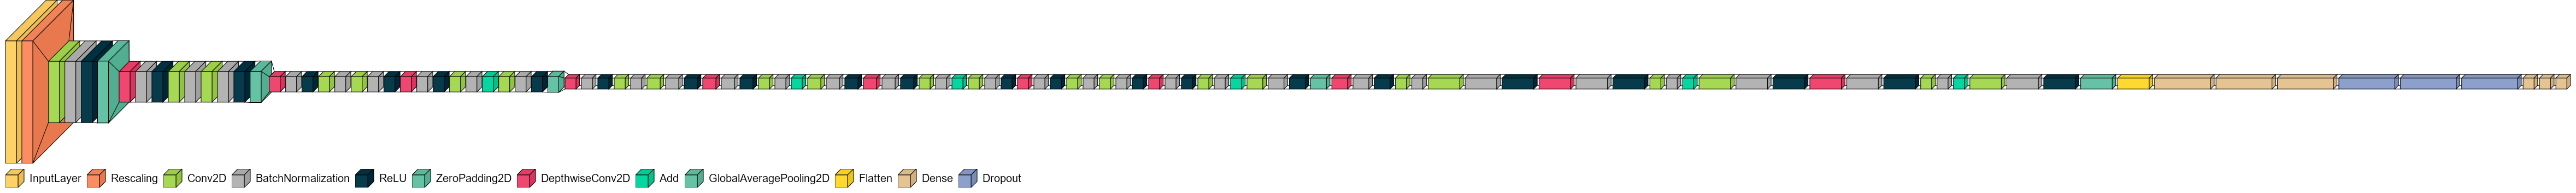

In [29]:
# # Impression des meilleurs hyperparamètres
# print("Best hyperparameters:", tuner.get_best_hyperparameters()[0].values)

# # Sauvegarde des meilleurs hyperparamètres
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# with open(path + "best_hp_mn.pkl", "wb") as f:
#     pickle.dump(best_hps, f)
    
# Chargement des meilleurs hyperparamètres
with open(path + "best_hp_mn.pkl", "rb") as f:
    loaded_best_hps = pickle.load(f)

# Construction du modèle avec les meilleurs hyperparamètres
model_mn = build_model(loaded_best_hps)    

# Visualisation du modèle
visualkeras.layered_view(model_mn, legend=True,  scale_xy=1, font=font, max_z=1000, color_map=color_map)    

In [30]:
# Création du rappel EarlyStopping
early_stopping = EarlyStopping(
    patience=5,
    monitor='val_loss',
    restore_best_weights=True)

# # Entraînement du modèle
# history = model_mn.fit(
#     train_generator,
#     epochs=EPOCHS,
#     validation_data=val_generator,
#     callbacks=[early_stopping]
# )

# # Sauvegarde du modèle
# model_mn.save(path + 'mod_mn2.h5')

In [31]:
def plot_epochs(history):
    fig, ax = plt.subplots(2, 3, figsize=(18, 10))

    # Age
    ax[0, 0].plot(history.history['age_mae'])
    ax[0, 0].plot(history.history['val_age_mae'])
    ax[0, 0].set_title('Age MAE', size=16)
    ax[0, 0].set_ylabel('Mean Absolute Error')
    ax[0, 0].legend(['Train', 'Validation'], loc='upper left')

    ax[1, 0].plot(history.history['age_loss'])
    ax[1, 0].plot(history.history['val_age_loss'])
    ax[1, 0].set_title('Age Loss', size=16)
    ax[1, 0].set_ylabel('Loss')
    ax[1, 0].legend(['Train', 'Validation'], loc='upper right')

    # Genre
    ax[0, 1].plot(history.history['gender_accuracy'])
    ax[0, 1].plot(history.history['val_gender_accuracy'])
    ax[0, 1].set_title('Gender Accuracy', size=16)
    ax[0, 1].set_ylabel('Accuracy')
    ax[0, 1].legend(['Train', 'Validation'], loc='upper left')

    ax[1, 1].plot(history.history['gender_loss'])
    ax[1, 1].plot(history.history['val_gender_loss'])
    ax[1, 1].set_title('Gender Loss', size=16)
    ax[1, 1].set_ylabel('Loss')
    ax[1, 1].legend(['Train', 'Validation'], loc='upper right')

    # Origine ethnique
    ax[0, 2].plot(history.history['ethnicity_f1_macro'])
    ax[0, 2].plot(history.history['val_ethnicity_f1_macro'])
    ax[0, 2].set_title('Ethnicity F1-Score Macro', size=16)
    ax[0, 2].set_ylabel('Accuracy')
    ax[0, 2].legend(['Train', 'Validation'], loc='upper left')

    ax[1, 2].plot(history.history['ethnicity_loss'])
    ax[1, 2].plot(history.history['val_ethnicity_loss'])
    ax[1, 2].set_title('Ethnicity Loss', size=16)
    ax[1, 2].set_ylabel('Loss')
    ax[1, 2].legend(['Train', 'Validation'], loc='upper right')

    for i in range(2):
        for j in range(3):
            ax[i, j].set_xlabel('Epoch')
            ax[i, j].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()
    
# plot_epochs(history)

In [32]:
custom_objects = {'age_output_mod': age_output_mod, 'f1_macro': f1_macro}

# Chargement du modèle avec les objets personnalisés
model_mn = load_model(path + 'mod_mn2.h5', custom_objects=custom_objects)

In [33]:
def evaluate_model(model, test_generator, dict_gender_accuracy, dict_ethnicity_f1_macro, label):
    loss, age_loss, gender_loss, ethnicity_loss, age_mae_log, gender_acc, ethnicity_f1 = model.evaluate(test_generator, verbose=0)

    dict_gender_accuracy[label] = gender_acc
    dict_ethnicity_f1_macro[label] = ethnicity_f1

    print(f'Gender accuracy: {gender_acc:.4f}')
    print(f'Ethnicity F1-Score Macro: {ethnicity_f1:.4f}')

In [34]:
evaluate_model(model_mn, test_generator, dict_gender_accuracy, dict_ethnicity_f1_macro, 'Baseline')

Gender accuracy: 0.9109
Ethnicity F1-Score Macro: 0.7801


In [35]:
# Définition d'une fonction pour décoder les étiquettes 
def decode_labels(log_age, gender, ethnicity):
    gender_str = "Male" if gender < 0.5 else "Female"
    ethnicity_str = ethnicity_mapping[ethnicity]
    age_str = int(np.exp(log_age))
    return f"Gender: {gender_str}\n Age: {age_str}\n Ethnicity: {ethnicity_str}"


def plot_true_pred_labels(model, test_generator):
    test_images, test_labels = next(test_generator)
    predictions = model.predict(test_images)
    fig, axes = plt.subplots(1, 5, figsize=(20, 8))
    for i in range(5):
        true_age, true_gender, true_ethnicity = test_labels[0][i], test_labels[1][i], test_labels[2][i]
        true_title = decode_labels(true_age, true_gender, true_ethnicity)
        pred_age, pred_gender, pred_ethnicity = predictions[0][i][0], predictions[1][i][0], np.argmax(predictions[2][i])
        pred_title = decode_labels(pred_age, pred_gender, pred_ethnicity)
        resized_image = cv2.resize(((test_images[i])).astype('uint8'), (200, 200), interpolation=cv2.INTER_AREA)
        axes[i].imshow(resized_image, cmap='gray')
        axes[i].set_title(f'True: {true_title}', fontsize=16)
        axes[i].axis('off')
        axes[i].text(0.5, -0.25, f'Pred: {pred_title}', size=16, ha="center", transform=axes[i].transAxes)
    plt.show()

2/2 [==============================] - 0s 49ms/step


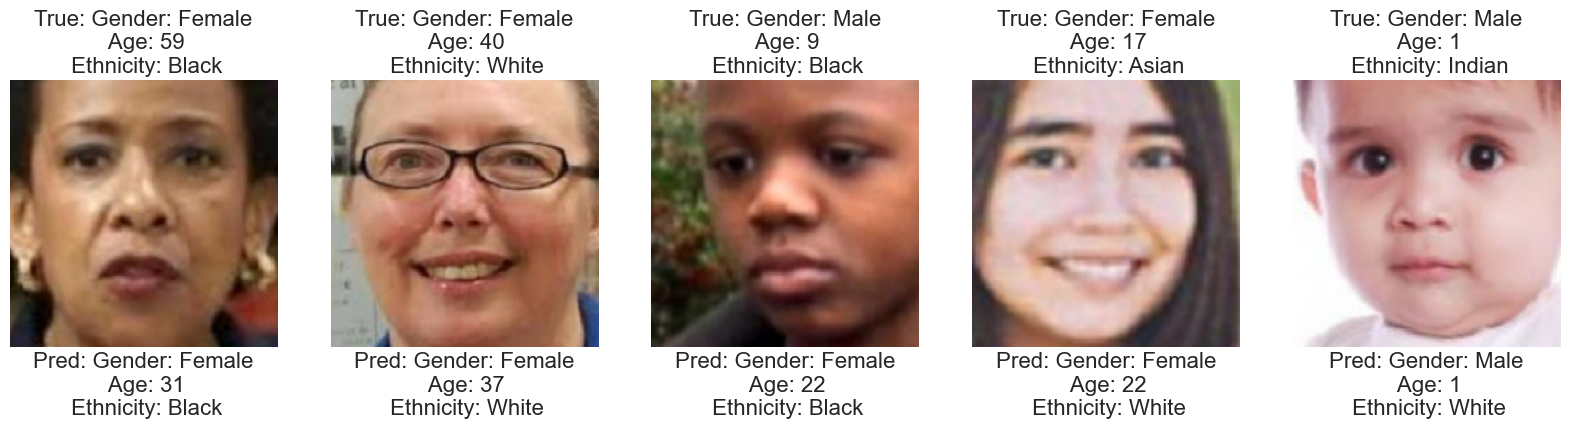

In [124]:
plot_true_pred_labels(model_mn, test_generator)

In [37]:
def get_true_and_pred_labels(test_generator, model):
    true_age_labels = []
    true_gender_labels = []
    true_ethnicity_labels = []

    pred_age_labels = []
    pred_gender_labels = []
    pred_ethnicity_labels = []

    for i, (images, labels) in enumerate(test_generator):

        true_age_labels.extend(np.round(np.exp(labels[0])).astype(int).tolist())
        true_gender_labels.extend(np.round(labels[1]).astype(int).tolist())
        true_ethnicity_labels.extend(labels[2].tolist())

        preds = model.predict(images)

        pred_age_labels.extend(np.round(np.exp(preds[0])).astype(int).tolist())
        pred_gender_labels.extend((preds[1] > 0.5).astype(int).tolist())
        pred_ethnicity_labels.extend(np.argmax(preds[2], axis=-1).tolist())
        
        if i+1 >= test_generator.n // test_generator.batch_size:
            break
    
    pred_age_labels = np.squeeze(pred_age_labels).tolist()
    pred_age_labels = np.clip(pred_age_labels, 1, None)
    pred_gender_labels = np.squeeze(pred_gender_labels).tolist()
    
    true_labels = np.vstack([true_age_labels, true_gender_labels, true_ethnicity_labels])
    pred_labels = np.vstack([pred_age_labels, pred_gender_labels, pred_ethnicity_labels])
    return true_labels, pred_labels

In [38]:
for param in ['gender', 'ethnicity']:
    true_labels, pred_labels = get_true_and_pred_labels(test_generator, model_mn)
    if param == 'gender':
        true_param_labels = true_labels[1]
        pred_param_labels = pred_labels[1]
    elif param == 'ethnicity':
        true_param_labels = true_labels[2]
        pred_param_labels = pred_labels[2]
    print(f"\nClassification report for {param}:")
    print(classification_report(true_param_labels, pred_param_labels))

2/2 [==============================] - 0s 68ms/step

Classification report for gender:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       322
           1       0.93      0.88      0.90       318

    accuracy                           0.91       640
   macro avg       0.91      0.91      0.91       640
weighted avg       0.91      0.91      0.91       640

2/2 [==============================] - 0s 71ms/step

Classification report for ethnicity:
              precision    recall  f1-score   support

           0       0.67      0.98      0.79       165
           1       0.83      0.90      0.86       167
           2       0.97      0.62      0.76       160
           3       0.89      0.69      0.78       148

    accuracy                           0.80       640
   macro avg       0.84      0.80      0.80       640
weighted avg       0.84      0.80      0.80       640



In [39]:
mae = mean_absolute_error(true_labels[0], pred_labels[0])
dict_age_mae['Baseline'] = mae
print(f"Age MAE: {mae:.1f}")

Age MAE: 10.2


In [40]:
def plot_confusion_matrices(true_labels, pred_labels):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
    titles = ['Matrice de confusion pour le genre', 'Matrice de confusion pour l\'origine ethnique']
    
    for i, ax in enumerate(axes.flat):
        cm = confusion_matrix(true_labels[i + 1, :], pred_labels[i + 1, :])
        heatmap = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', square=True, cbar=False,
                              annot_kws={"fontsize": 15}, ax=ax)
        heatmap.set_xlabel('Pred', fontsize=15)
        heatmap.set_ylabel('True', fontsize=15)
        heatmap.set_title(titles[i], fontsize=20)
        heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=14)
        heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=14)
    
    plt.tight_layout()
    plt.show()

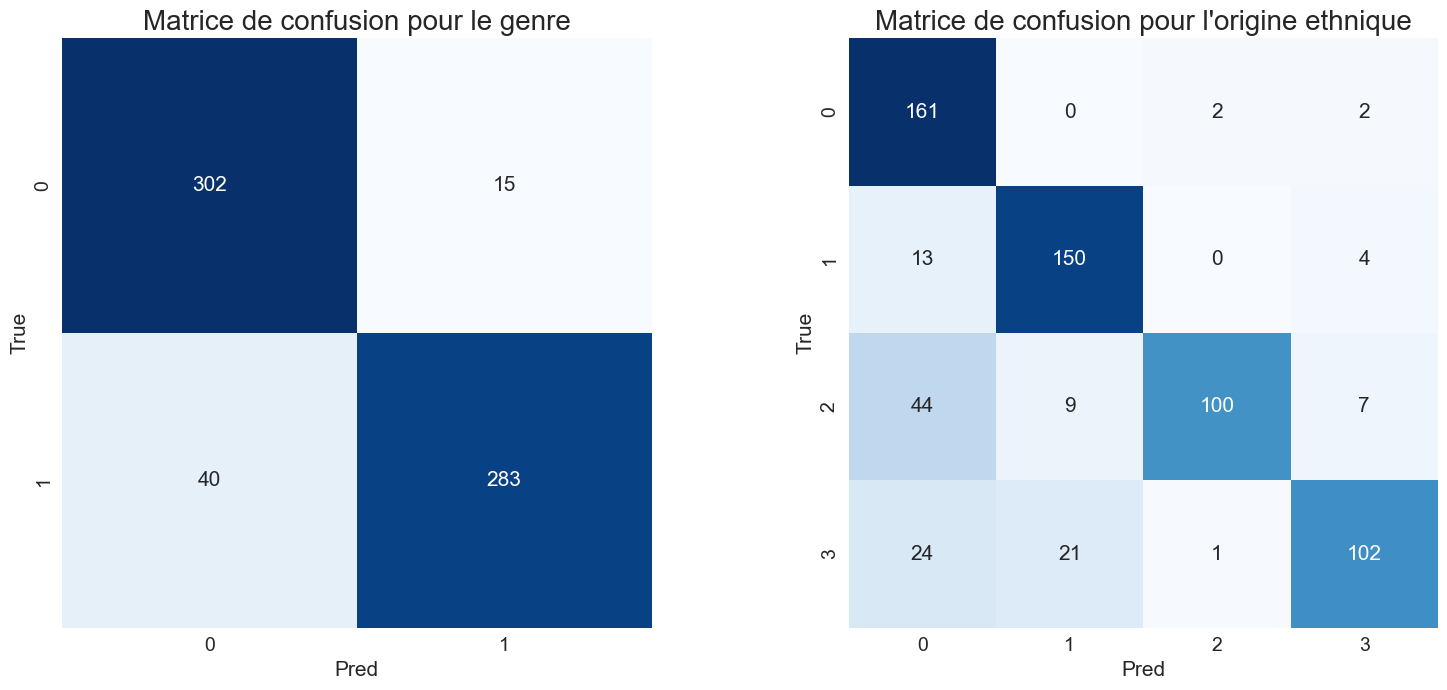

In [41]:
plot_confusion_matrices(true_labels, pred_labels)

In [42]:
def plot_age_mae_box(true_labels, pred_labels):
    age_errors = np.abs(true_labels[0] - pred_labels[0])
    age_error_df = pd.DataFrame({'Age': true_labels[0], 'Error': age_errors})

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=age_error_df, x='Age', y='Error', showfliers=False)
    plt.xlabel('Age', fontsize=15)
    plt.xticks(ticks=range(0-1, max(true_labels[0]) + 1, 5))
    plt.ylabel('MAE', fontsize=15)
    plt.title('Erreur absolue moyenne par âge', fontsize=18)
    plt.grid(True)
    plt.show()

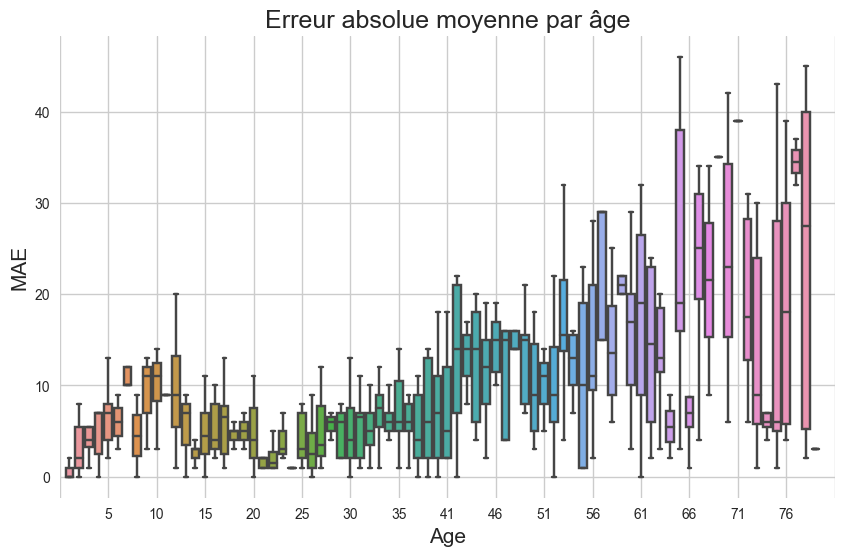

In [43]:
plot_age_mae_box(true_labels, pred_labels)

In [44]:
def plot_agerange_mae_box(true_labels, pred_labels):
    age_errors = np.abs(true_labels[0] - pred_labels[0])
    age_error_df = pd.DataFrame({'Age': true_labels[0], 'Error': age_errors})

    # Définir les tranches d'âge
    bins = list(range(0, max(true_labels[0]) + 10, 10))
    age_error_df['Age'] = pd.cut(age_error_df['Age'], bins=bins)

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=age_error_df, x='Age', y='Error', showfliers=False)
    plt.xlabel('Tranche d\'âge', fontsize=15)
    plt.xticks(rotation=45)
    plt.ylabel('MAE', fontsize=15)
    plt.title('Erreur absolue moyenne par tranche d\'âge', fontsize=18)
    plt.grid(True)
    plt.show()

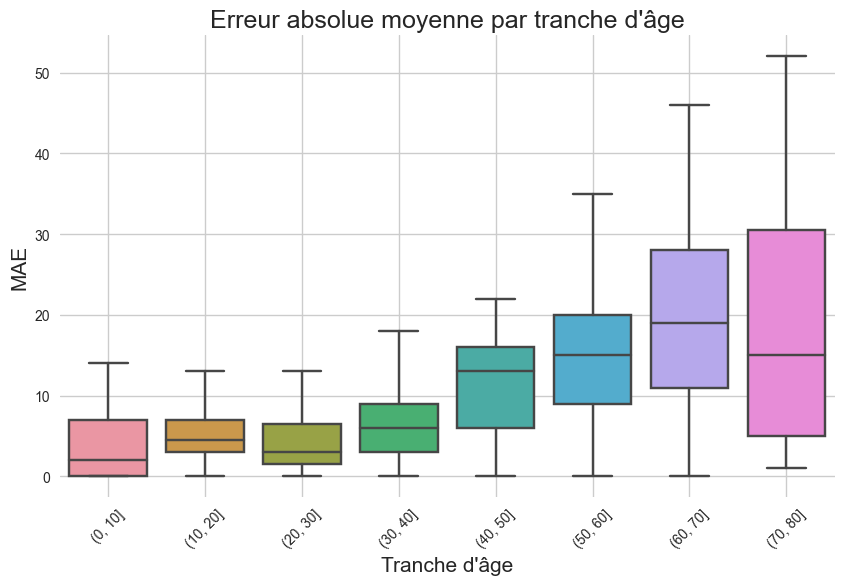

In [45]:
plot_agerange_mae_box(true_labels, pred_labels)

## <font color="#114b98" id="section_5">5. Pondération des échantillons lors de l'entraînement</font>

In [46]:
'''
Inverse du nombre d'échantillons (INS) :
Cette méthode attribue un poids à chaque échantillon en tant 
qu'inverse de la fréquence de la classe à laquelle il appartient. 
Elle a tendance à mettre plus l'accent sur les classes minoritaires, 
ce qui peut aider le modèle à apprendre les modèles de la classe 
sous-représentée plus efficacement.
'''

def compute_sample_weights(y):
    class_counts = np.bincount(y)
    sample_weights = 1 / class_counts[y]
    sample_weights /= np.sum(sample_weights)
    return sample_weights

train_weights_eth = compute_sample_weights(train_df['ethnicity'])

train_generator_w = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col=['log_age', 'gender', 'ethnicity'],
    target_size=image_size,
    batch_size=batch_size,
    class_mode='multi_output',
    color_mode="rgb",
    shuffle=True,
    seed=42,
    sample_weight=train_weights_eth,
)

# Chargement des meilleurs hyperparamètres
with open(path + "best_hp_mn.pkl", "rb") as f:
    loaded_best_hps = pickle.load(f)

# Construction du modèle avec les meilleurs hyperparamètres
model_mn_w = build_model(loaded_best_hps)

# # Entraînement du modèle
# history = model_mn_w.fit(
#     train_generator_w,
#     epochs=EPOCHS,
#     validation_data=val_generator,
#     callbacks=[early_stopping]
# )

Found 14667 validated image filenames.


In [47]:
# # Sauvegarde du modèle
# model_mn_w.save(path + 'mod_mn_w.h5')

# Chargement du modèle avec les objets personnalisés
model_mn_w = load_model(path + 'mod_mn_w.h5', custom_objects=custom_objects)

In [48]:
# Évaluation du modèle
evaluate_model(model_mn_w, test_generator, dict_gender_accuracy, dict_ethnicity_f1_macro, 'Weighted')

Gender accuracy: 0.9187
Ethnicity F1-Score Macro: 0.7973


In [49]:
for param in ['gender', 'ethnicity']:
    true_labels_w, pred_labels_w = get_true_and_pred_labels(test_generator, model_mn_w)
    if param == 'gender':
        true_param_labels = true_labels_w[1]
        pred_param_labels = pred_labels_w[1]
    elif param == 'ethnicity':
        true_param_labels = true_labels_w[2]
        pred_param_labels = pred_labels_w[2]
    print(f"\nClassification report for {param}:")
    print(classification_report(true_param_labels, pred_param_labels))

2/2 [==============================] - 0s 53ms/step

Classification report for gender:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       326
           1       0.92      0.93      0.92       314

    accuracy                           0.93       640
   macro avg       0.92      0.93      0.92       640
weighted avg       0.93      0.93      0.93       640

2/2 [==============================] - 0s 54ms/step

Classification report for ethnicity:
              precision    recall  f1-score   support

           0       0.67      0.96      0.79       157
           1       0.86      0.90      0.88       159
           2       0.97      0.59      0.74       160
           3       0.86      0.79      0.82       164

    accuracy                           0.81       640
   macro avg       0.84      0.81      0.81       640
weighted avg       0.84      0.81      0.81       640



In [50]:
mae = mean_absolute_error(true_labels_w[0], pred_labels_w[0])
dict_age_mae['Weighted'] = mae
print(f"Age MAE: {mae:.1f}")

Age MAE: 9.8


In [51]:
def plot_comparison(dict_age_mae, dict_gender_accuracy, dict_ethnicity_f1_macro):
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    dict_list = [dict_age_mae, dict_gender_accuracy, dict_ethnicity_f1_macro]
    labels_list = ['Age MAE', 'Gender Accuracy', 'Ethnicity F1-Score Macro']

    flattened_axs = axs.flatten()
    for i in range(3):
        dict_data = dict_list[i]
        labels = list(dict_data.keys())
        values = list(dict_data.values())
        sns.barplot(x=labels, y=values, palette=sns.color_palette("rocket_r"), ax=flattened_axs[i])
        flattened_axs[i].set_title(labels_list[i], fontsize=16)
        
        # Set the ylim to accommodate the text above the bars
        max_value = max(values)
        flattened_axs[i].set_ylim(0, max_value * 1.1)
        
        for j, v in enumerate(values):
            flattened_axs[i].text(j, v + 0.01 * max_value, f"{round(v, 3)}", ha='center', fontsize=12)
        flattened_axs[i].set_xticklabels(labels, fontsize=14, rotation=90)
    plt.tight_layout()
    plt.show()

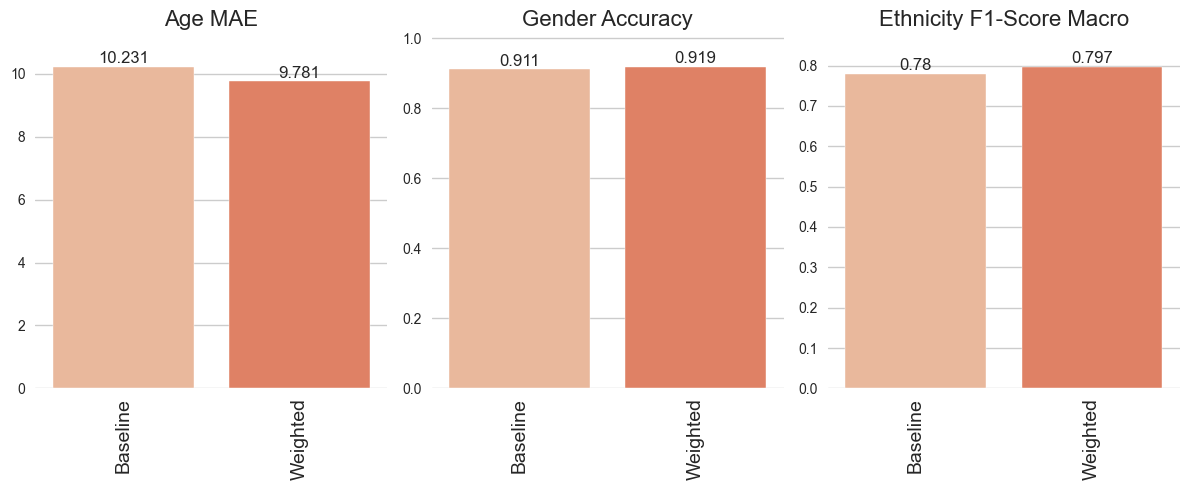

In [52]:
plot_comparison(dict_age_mae, dict_gender_accuracy, dict_ethnicity_f1_macro)

## <font color="#114b98" id="section_6">6. Sous-échantillonage de la classe majoritaire</font>

In [53]:
# Définition de la stratégie d'échantillonnage pour la classe majoritaire
sampling_strategy = {0: int(np.sum(train_df['ethnicity'] == 0) / 2)}

# Initialisation du RandomUnderSampler avec la stratégie d'échantillonnage définie
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)

# Échantillonnage des données
X = train_df.drop(columns=['ethnicity'])
y = train_df['ethnicity']
X_resampled, y_resampled = rus.fit_resample(X, y)

# Création du DataFrame avec les données échantillonnées
train_df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

train_generator_us = train_datagen.flow_from_dataframe(
    train_df_resampled,
    x_col='image_path',
    y_col=['log_age', 'gender', 'ethnicity'],
    target_size=image_size,
    batch_size=batch_size,
    class_mode='multi_output',
    color_mode="rgb",
    shuffle=True,
    seed=42,
)

# Chargement des meilleurs hyperparamètres
with open(path + "best_hp_mn.pkl", "rb") as f:
    loaded_best_hps = pickle.load(f)
    
# Construction du modèle avec les meilleurs hyperparamètres
model_mn_us = build_model(loaded_best_hps) 

# # Entraînement du modèle
# history = model_mn_us.fit(
#     train_generator_us,
#     epochs=EPOCHS,                            
#     validation_data=val_generator,
#     callbacks=[early_stopping]
# )

Found 10892 validated image filenames.


In [54]:
# # Sauvegarde du modèle
# model_mn_us.save(path + 'mod_mn_us.h5')

# Chargement du modèle avec les objets personnalisés
model_mn_us = load_model(path + 'mod_mn_us.h5', custom_objects=custom_objects)

In [55]:
# Évaluation du modèle
evaluate_model(model_mn_us, test_generator, dict_gender_accuracy, dict_ethnicity_f1_macro, 'Down\nSampling')

Gender accuracy: 0.9047
Ethnicity F1-Score Macro: 0.8033


In [56]:
for param in ['gender', 'ethnicity']:
    true_labels_us, pred_labels_us = get_true_and_pred_labels(test_generator, model_mn_us)
    if param == 'gender':
        true_param_labels = true_labels_us[1]
        pred_param_labels = pred_labels_us[1]
    elif param == 'ethnicity':
        true_param_labels = true_labels_us[2]
        pred_param_labels = pred_labels_us[2]
    print(f"\nClassification report for {param}:")
    print(classification_report(true_param_labels, pred_param_labels))

2/2 [==============================] - 0s 63ms/step

Classification report for gender:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       315
           1       0.92      0.91      0.91       325

    accuracy                           0.91       640
   macro avg       0.91      0.91      0.91       640
weighted avg       0.91      0.91      0.91       640

2/2 [==============================] - 0s 54ms/step

Classification report for ethnicity:
              precision    recall  f1-score   support

           0       0.66      0.96      0.79       162
           1       0.92      0.87      0.90       163
           2       0.99      0.53      0.69       160
           3       0.84      0.90      0.87       155

    accuracy                           0.82       640
   macro avg       0.85      0.82      0.81       640
weighted avg       0.85      0.82      0.81       640



In [57]:
mae = mean_absolute_error(true_labels_us[0], pred_labels_us[0])
dict_age_mae['Down\nSampling'] = mae
print(f"Age MAE: {mae:.1f}")

Age MAE: 9.3


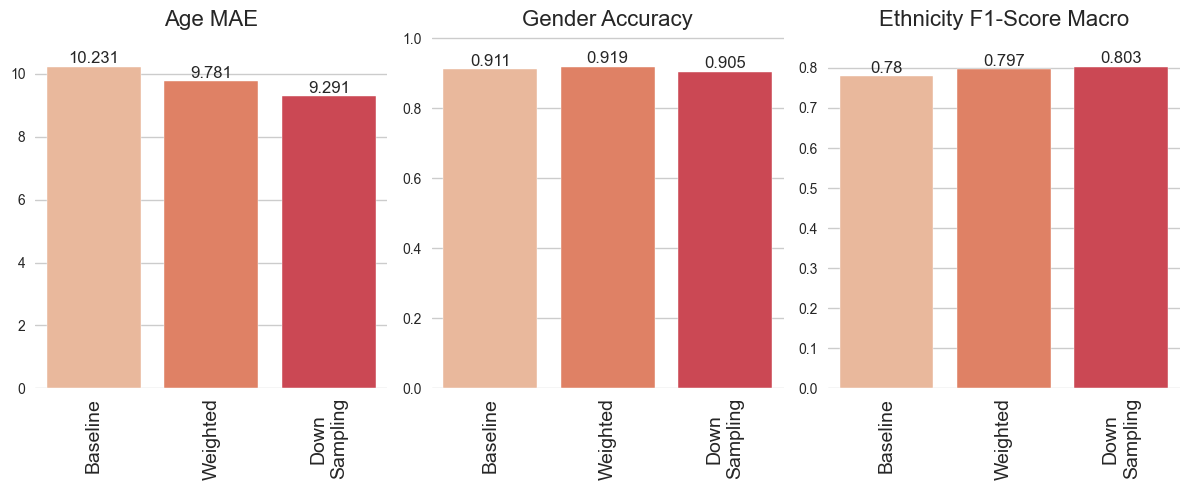

In [58]:
plot_comparison(dict_age_mae, dict_gender_accuracy, dict_ethnicity_f1_macro)

## <font color="#114b98" id="section_7">7. Implémentation de DenseWeight & LMFLoss</font>

In [59]:
'''
DenseWeight et DenseLoss sont deux méthodes complémentaires utilisées
pour gérer les problèmes de régression déséquilibrés lors de l'entraînement
d'un modèle d'apprentissage automatique.

DenseWeight est une méthode qui attribue des poids à chaque échantillon
de l'ensemble de données d'entraînement en fonction de la rareté de leurs 
valeurs cibles. Cela est conçu pour aider le modèle à prêter davantage 
attention aux cas rares, qui sont généralement plus difficiles à prédire. 
Le paramètre alpha contrôle l'intensité du schéma de pondération basé sur 
la densité, où alpha = 0.0 signifie une pondération uniforme, et des valeurs
d'alpha plus grandes mettent davantage l'accent sur les échantillons rares. 
La rareté d'une valeur cible est jugée sur la base de sa densité, obtenue 
grâce à l'estimation de densité par noyau (KDE).

DenseLoss est une fonction de perte personnalisée utilisée pendant l'entraînement 
du modèle. La fonction de perte est ce que le modèle optimise. Elle informe 
le modèle de la qualité de ses performances. Dans ce cas, la fonction DenseLoss 
est une erreur absolue moyenne pondérée (MAE) qui utilise les poids calculés 
par la méthode DenseWeight.

L'utilisation de DenseWeight et DenseLoss ensemble est logique car elles sont 
conçues pour travailler ensemble. DenseWeight ajuste l'importance de chaque 
échantillon dans l'ensemble de données d'entraînement en fonction de la rareté 
de leurs valeurs cibles, tandis que DenseLoss veille à ce que ces poids soient 
pris en compte lorsque le modèle apprend de ses erreurs.
'''

# Extraction de la variable cible
y = train_df['log_age'] 

# Calcul des poids des classes en utilisant DenseWeight
dw = DenseWeight(alpha=0.25)
train_weights_age = dw.fit(np.ravel(y))

def multi_output_gen(df, datagen, image_size, batch_size):
    gen = datagen.flow_from_dataframe(
        df,
        x_col='image_path',
        y_col=['log_age', 'gender', 'ethnicity'],
        target_size=image_size,
        batch_size=batch_size,
        class_mode='multi_output',
        color_mode="rgb",
        shuffle=True,
        seed=42
    )

    while True:
        gnext = gen.next()
        yield gnext[0], {
            'age': gnext[1][0],
            'gender': gnext[1][1],
            'ethnicity': gnext[1][2]
        }, {
            'age': train_weights_age,
            'gender': None,
            'ethnicity': None
        }


train_generator_imba = multi_output_gen(train_df, train_datagen, image_size, batch_size)

    
class DenseLoss(losses.Loss):
    def __init__(self, alpha, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.dw = DenseWeight(alpha=self.alpha)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "alpha": self.alpha}

    def call(self, y_true, y_pred):
        # Flatten y_true and y_pred to 1D array
        y_true = K.flatten(y_true)
        y_pred = K.flatten(y_pred)

        # Compute weights
        weights = self.dw.fit(np.ravel(y_true.numpy()))

        # Calculate mean absolute error
        mae = K.mean(weights * K.abs(y_true - y_pred), axis=-1)

        return mae

In [60]:
'''
LMFLoss est une fonction de perte personnalisée qui combine les 
avantages de la perte Focale et de la perte LDAM pour traiter le 
problème du déséquilibre des classes dans les tâches de classification.

Les classes majoritaires sont pénalisées en augmentant leur marge 
dans la perte LDAM, rendant leur classification plus difficile pour 
le modèle. En parallèle, la perte Focal augmente l'attention portée 
aux classes minoritaires en réduisant le poids des exemples facilement 
classifiables.

La marge pour chaque classe est contrôlée par la liste "ldam_margin_list",
qui est calculée à partir de la distribution des classes. Les classes 
majoritaires se voient attribuer une marge plus importante pour encourager 
le modèle à se concentrer davantage sur les classes minoritaires.

Les paramètres alpha et gamma contrôlent respectivement la pondération des 
classes dans le calcul de cette perte, le poids de la perte Focal. 
'''

class LMFLoss(losses.Loss):
    def __init__(self, cls_num_list, gamma=1.5, alpha=0.5, beta=0.5, margin_constant=1.0, reduction=tf.keras.losses.Reduction.AUTO, **kwargs):
        super(LMFLoss, self).__init__(reduction=reduction, **kwargs)

        self.cls_num_list = cls_num_list
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.margin_constant = margin_constant

        # Calcul des valeurs des marges LDAM
        ldam_margin_list = [margin_constant / (c / sum(cls_num_list)) ** 0.25 for c in cls_num_list]
        self.ldam_margin_list = tf.convert_to_tensor(ldam_margin_list, dtype=tf.float32)

    def get_config(self):
        config = super(LMFLoss, self).get_config()
        config.update({
            'cls_num_list': self.cls_num_list,
            'gamma': self.gamma,
            'alpha': self.alpha,
            'beta': self.beta,
        })
        return config

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Calcul de la Focal loss
        focal_loss = -self.alpha * tf.pow(1. - y_pred, self.gamma) * tf.math.log(y_pred)
        focal_loss = tf.reduce_sum(focal_loss, axis=-1)

        # Calcul de la LDAM loss
        y_true_one_hot = tf.one_hot(y_true, depth=len(self.cls_num_list))
        y_true_one_hot_squeezed = tf.squeeze(y_true_one_hot, axis=1)
        mask = tf.cast(y_true_one_hot_squeezed, dtype=bool)
        y_pred_margins = tf.where(mask, y_pred - self.ldam_margin_list, y_pred)
        ldma_loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_true_one_hot, logits=y_pred_margins)

        # Combinaison de Focal loss et LDAM loss
        loss = self.alpha * ldma_loss + self.beta * focal_loss

        return tf.reduce_mean(loss)


# Extraction des étiquettes de classe uniques à partir de la colonne 'ethnicity' dans le DataFrame train_df
unique_classes_train = train_df['ethnicity'].unique()

# Tri des étiquettes de classe uniques
unique_classes_train_sorted = np.sort(unique_classes_train)

# Calcul des fréquences de classe en fonction des étiquettes de classe uniques triées
cls_num_list = train_df['ethnicity'].value_counts().loc[unique_classes_train_sorted].values

In [61]:
# Définition de la fonction de création de modèle pour Keras Tuner
def build_model(hp):

    input_layer = Input(input_shape)

    base_model = MobileNetV3Small(
        weights='imagenet',
        include_top=False,
        input_tensor=input_layer,
        minimalistic = True
    )
    
    for layer in base_model.layers:
        layer.trainable = True
 
    x = GlobalAveragePooling2D()(base_model.output)
    x = Flatten()(x)

    dense_size = 1024
    dropout_rate = 0.2
       
    x_age = Dense(dense_size, activation='relu', kernel_initializer='he_normal')(x)
    x_age = Dropout(dropout_rate)(x_age)
    age_output = Dense(1, activation=age_output_mod, name='age')(x_age)

    x_gender = Dense(dense_size, activation='relu', kernel_initializer='he_normal')(x)
    x_gender = Dropout(dropout_rate)(x_gender)
    gender_output = Dense(1, activation='sigmoid', name='gender')(x_gender)

    x_ethnicity = Dense(dense_size, activation='relu', kernel_initializer='he_normal')(x)
    x_ethnicity = Dropout(dropout_rate)(x_ethnicity)
    ethnicity_output = Dense(classes_eth, activation='softmax', name='ethnicity')(x_ethnicity)

    model = Model(inputs=input_layer, 
                  outputs=[age_output, gender_output, ethnicity_output],
                  name="model_imba")

    alpha_age = hp.Choice('alpha_age', [0.10, 0.25, 0.50, 0.75, 1.25, 2.0])
    alpha_eth = hp.Choice('alpha_eth', [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.25, 2.0])
    beta = hp.Choice('beta', [0.1, 0.05, 0.1, 0.05, 1.0, 2.0])    
    gamma = hp.Choice('gamma', [1.0, 2.0, 2.5, 3.0, 3.5, 4.5, 5.5])    
    margin_constant = 1.0 

    ethnicity_loss = LMFLoss(cls_num_list, gamma=gamma, alpha=alpha_eth, beta=beta, margin_constant=margin_constant)
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001, clipnorm=1.0),
        loss={
            'age': DenseLoss(alpha=alpha_age),
            'gender': 'binary_crossentropy',
            'ethnicity': ethnicity_loss
        },
        loss_weights={
            'age': 2.0,
            'gender': 1.0,
            'ethnicity': 2.0
        },
        metrics={
            'age': 'mae',
            'gender': 'accuracy',
            'ethnicity': f1_macro
        }
    )
    return model


EPOCHS = 25
MAX_TRIALS = 40

tuner_imba = BayesianOptimization(
    build_model,
    objective=[age_mae_objective, gender_accuracy_objective, ethnicity_f1_objective],
    max_trials=MAX_TRIALS,
    num_initial_points=4,
    directory="keras_tuner",
    project_name="tuner_hp_mn_imba",
    overwrite=True
)

steps_per_epoch = len(train_df) // batch_size

# tuner_imba.search(train_generator_imba,
#                   steps_per_epoch=steps_per_epoch,
#                   epochs=EPOCHS,
#                   validation_data=val_generator,
#                   callbacks=[build_callbacks()])

In [62]:
# # Impression des meilleurs hyperparamètres
# print("Best hyperparameters:", tuner_imba.get_best_hyperparameters()[0].values)

In [63]:
# # Sauvegarde des meilleurs hyperparamètres
# best_hps_ = tuner_imba.get_best_hyperparameters(num_trials=1)[0]
# with open(path + "best_hp_mn_imba5.pkl", "wb") as f:
#     pickle.dump(best_hps_, f)

In [64]:
# Chargement des meilleurs hyperparamètres
with open(path + "best_hp_mn_imba5.pkl", "rb") as f:
    loaded_best_hps_ = pickle.load(f)

In [65]:
# # Récupération du meilleur modèle
# model_mn_imba = tuner_imba.get_best_models(num_models=1)[0]

# # Sauvegarde du modèle
# model_mn_imba.save(path + 'model_mn_imba5.h5')

In [66]:
# Définition d'un dictionnaire contenant les objets personnalisés
custom_objects_ = {'LMFLoss': LMFLoss(cls_num_list, gamma=4.0, alpha=2.5, beta=0.05, margin_constant=1.0),
                   'age_output_mod': age_output_mod,
                   'f1_macro': f1_macro,
                   'DenseLoss': DenseLoss(0.25)}

# Impression des hyperparamètres
print("LMFLoss hyperparameters: ", custom_objects_['LMFLoss'].get_config())
print("DenseLoss hyperparameters: ", custom_objects_['DenseLoss'].get_config())

# Chargement du modèle avec les objets personnalisés
model_mn_imba = load_model(path + 'model_mn_imba5.h5', custom_objects=custom_objects_)

LMFLoss hyperparameters:  {'reduction': 'auto', 'name': None, 'cls_num_list': array([7549, 3406,  638, 3074], dtype=int64), 'gamma': 4.0, 'alpha': 2.5, 'beta': 0.05}
DenseLoss hyperparameters:  {'reduction': 'auto', 'name': None, 'alpha': 0.25}


In [109]:
 # Évaluation du modèle
evaluate_model(model_mn_imba, test_generator, dict_gender_accuracy, dict_ethnicity_f1_macro, 'DenseWeight\n+ LMFLoss')

Gender accuracy: 0.9196
Ethnicity F1-Score Macro: 0.8214


In [110]:
for param in ['gender', 'ethnicity']:
    true_labels_imba, pred_labels_imba = get_true_and_pred_labels(test_generator, model_mn_imba)
    
    if param == 'gender':
        true_param_labels = true_labels_imba[1]
        pred_param_labels = pred_labels_imba[1]
    elif param == 'ethnicity':
        true_param_labels = true_labels_imba[2]
        pred_param_labels = pred_labels_imba[2]
               
    print(f"\nClassification report for {param}:")
    print(classification_report(true_param_labels, pred_param_labels))

2/2 [==============================] - 0s 51ms/step

Classification report for gender:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       322
           1       0.91      0.93      0.92       318

    accuracy                           0.92       640
   macro avg       0.92      0.92      0.92       640
weighted avg       0.92      0.92      0.92       640

2/2 [==============================] - 0s 48ms/step

Classification report for ethnicity:
              precision    recall  f1-score   support

           0       0.72      0.95      0.82       154
           1       0.85      0.91      0.88       150
           2       1.00      0.57      0.72       176
           3       0.83      0.91      0.87       160

    accuracy                           0.82       640
   macro avg       0.85      0.83      0.82       640
weighted avg       0.85      0.82      0.82       640



In [111]:
mae = mean_absolute_error(true_labels_imba[0], pred_labels_imba[0])
dict_age_mae['DenseWeight\n+ LMFLoss'] = mae
print(f"Age MAE: {mae:.1f}")

Age MAE: 8.9


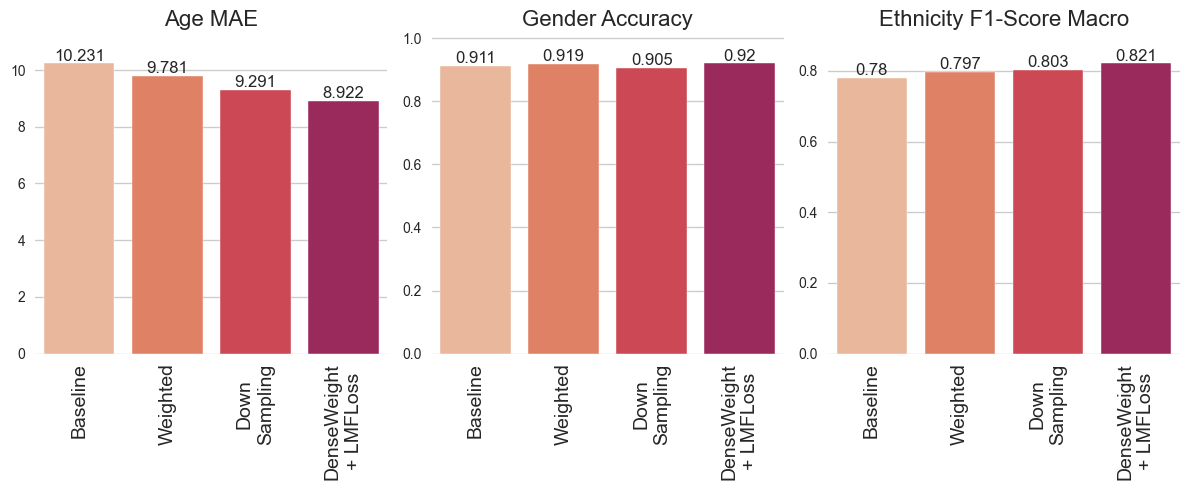

In [112]:
plot_comparison(dict_age_mae, dict_gender_accuracy, dict_ethnicity_f1_macro)

2/2 [==============================] - 0s 53ms/step


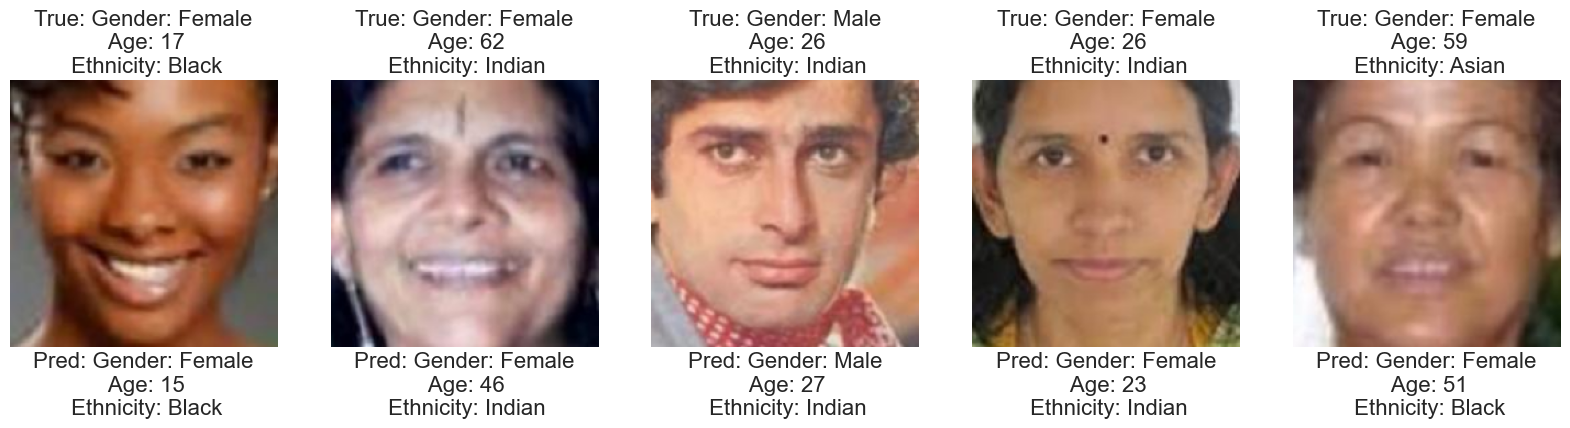

In [147]:
plot_true_pred_labels(model_mn_imba, test_generator)

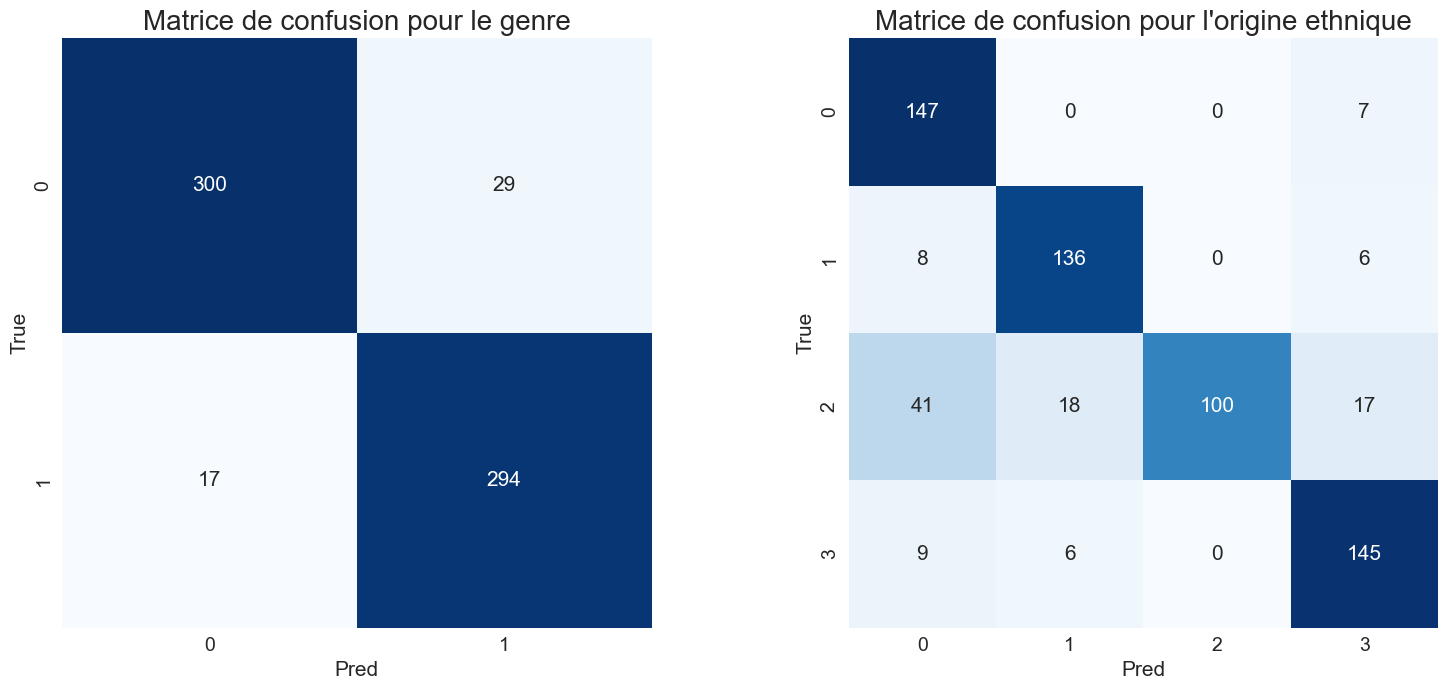

In [146]:
plot_confusion_matrices(true_labels_imba, pred_labels_imba)

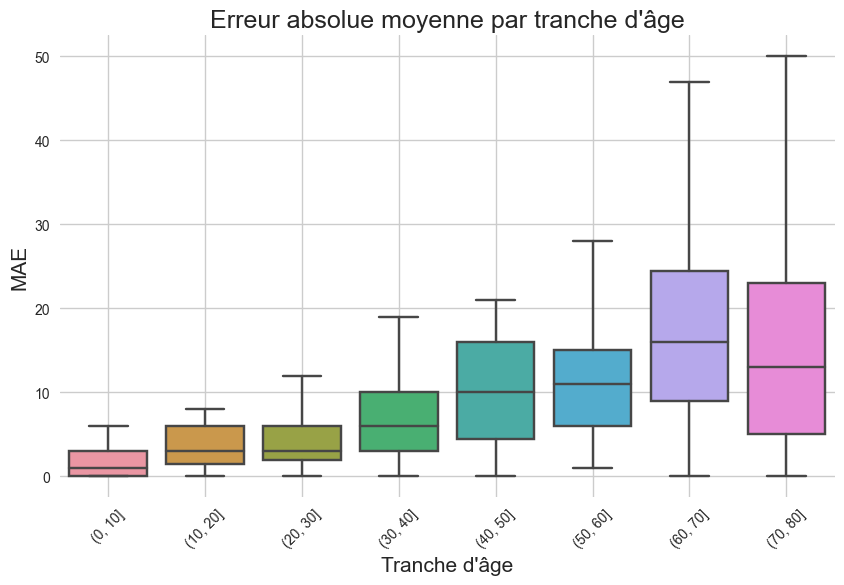

In [115]:
plot_agerange_mae_box(true_labels_imba, pred_labels_imba)

## <font color="#114b98" id="section_7">7. Comparaison des performances</font>

### <font color="#114b98"> a) Performances sur la prédiction du genre</font>

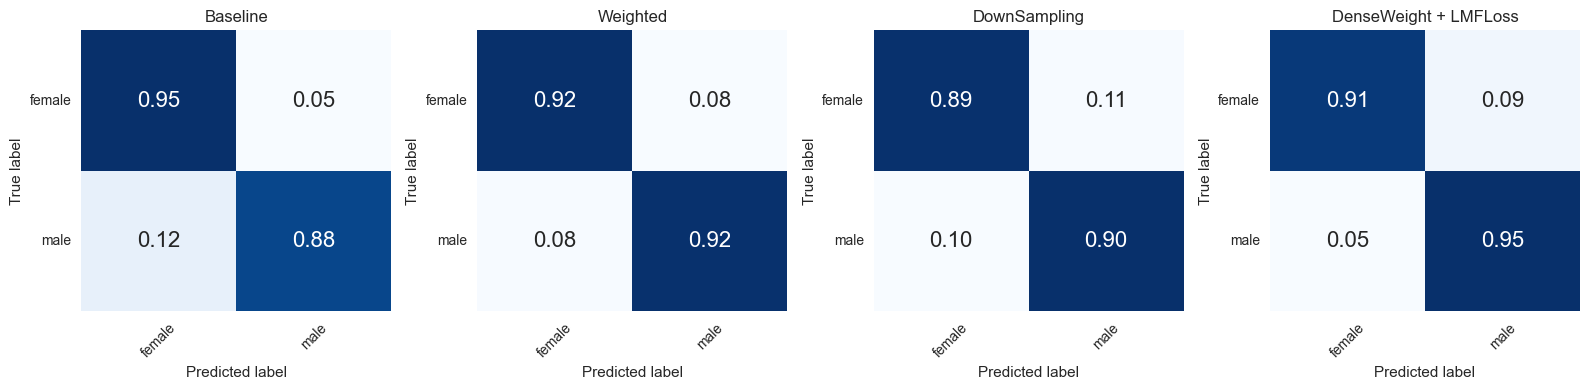

In [116]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap='Blues'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    ax = sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap, annot_kws={"size": 16}, cbar=False)
    ax.set_title(title)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes, rotation=0)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

cnf_matrix_mn_gender = confusion_matrix(true_labels[1], pred_labels[1])
cnf_matrix_mn_w_gender = confusion_matrix(true_labels_w[1], pred_labels_w[1])
cnf_matrix_mn_us_gender = confusion_matrix(true_labels_us[1], pred_labels_us[1])
cnf_matrix_mn_imba_gender = confusion_matrix(true_labels_imba[1], pred_labels_imba[1])

plt.figure(figsize=(16,4))
plt.subplot(1, 4, 1)
plot_confusion_matrix(cnf_matrix_mn_gender, classes=['female', 'male'], title='Baseline', cmap='Blues')
plt.subplot(1, 4, 2)
plot_confusion_matrix(cnf_matrix_mn_w_gender, classes=['female', 'male'], title='Weighted', cmap='Blues')
plt.subplot(1, 4, 3)
plot_confusion_matrix(cnf_matrix_mn_us_gender, classes=['female', 'male'], title='DownSampling', cmap='Blues')
plt.subplot(1, 4, 4)
plot_confusion_matrix(cnf_matrix_mn_imba_gender, classes=['female', 'male'], title='DenseWeight + LMFLoss', cmap='Blues')
plt.tight_layout()
plt.show()

En observant les résultats, il apparaît que les méthodes appliquées n'ont pas eu d'impact significatif sur la classification du genre. En effet, les variations de l'accuracy, qui sont de l'ordre de plus ou moins 1% avec les différentes méthodes, peuvent être considérées comme négligeables. De plus, il est important de noter que dans ce cas particulier, il n'y avait pas de déséquilibre initial concernant cette caractéristique. Par conséquent, il semble que l'application de ces méthodes n'a pas contribué de manière substantielle à améliorer la précision de la classification du genre

### <font color="#114b98"> b) Performances sur la prédiction de l'origine ethnique</font>

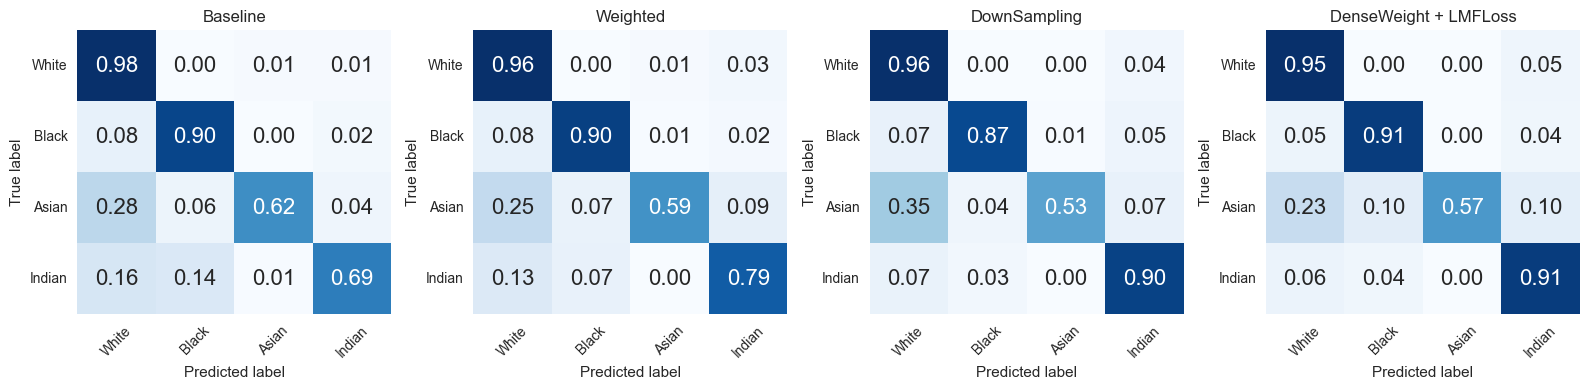

In [117]:
cnf_matrix_mn_ethnicity = confusion_matrix(true_labels[2], pred_labels[2])
cnf_matrix_mn_w_ethnicity = confusion_matrix(true_labels_w[2], pred_labels_w[2])
cnf_matrix_mn_us_ethnicity = confusion_matrix(true_labels_us[2], pred_labels_us[2])
cnf_matrix_mn_imba_ethnicity = confusion_matrix(true_labels_imba[2], pred_labels_imba[2])

plt.figure(figsize=(16,4))
plt.subplot(1, 4, 1)
plot_confusion_matrix(cnf_matrix_mn_ethnicity, classes=ethnicity_mapping.values(), title='Baseline', cmap='Blues')
plt.subplot(1, 4, 2)
plot_confusion_matrix(cnf_matrix_mn_w_ethnicity, classes=ethnicity_mapping.values(), title='Weighted', cmap='Blues')
plt.subplot(1, 4, 3)
plot_confusion_matrix(cnf_matrix_mn_us_ethnicity, classes=ethnicity_mapping.values(), title='DownSampling', cmap='Blues')
plt.subplot(1, 4, 4)
plot_confusion_matrix(cnf_matrix_mn_imba_ethnicity, classes=ethnicity_mapping.values(), title='DenseWeight + LMFLoss', cmap='Blues')
plt.tight_layout()
plt.show()

La méthode mise en œuvre n'a pas résolu le problème lié à la prédiction de la classe "Asian", comme en témoigne le maintien d'un score F1 bas. Cependant, elle a permis d'améliorer notablement les scores des trois autres classes. Par conséquent, bien que l'approche employée ait montré des limites dans la prédiction de certaines classes, elle a néanmoins contribué à une meilleure distinction des autres catégories ethniques.

In [118]:
palette=sns.color_palette("rocket_r")
colors = ['#%02x%02x%02x' % (int(r*255), int(g*255), int(b*255)) for r, g, b in palette]

ethnicities = ['White', 'Black', 'Asian', 'Indian']
fig = make_subplots(rows=2, cols=2, subplot_titles=ethnicities)

for i, ethnicity in enumerate(ethnicities):
    row = i // 2 + 1
    col = i % 2 + 1

    true_class = [int(true_labels[2][j] == i) for j in range(len(true_labels[2]))]
    true_class_w = [int(true_labels_w[2][j] == i) for j in range(len(true_labels_w[2]))]
    true_class_us = [int(true_labels_us[2][j] == i) for j in range(len(true_labels_us[2]))]
    true_class_imba = [int(true_labels_imba[2][j] == i) for j in range(len(true_labels_imba[2]))]
        
    pred_class = [int(pred_labels[2][j] == i) for j in range(len(pred_labels[2]))]
    pred_class_w = [int(pred_labels_w[2][j] == i) for j in range(len(pred_labels_w[2]))]
    pred_class_us = [int(pred_labels_us[2][j] == i) for j in range(len(pred_labels_us[2]))]    
    pred_class_imba = [int(pred_labels_imba[2][j] == i) for j in range(len(pred_labels_imba[2]))]
    
    f1_score_m1 = f1_score(true_class, pred_class)
    f1_score_m2 = f1_score(true_class_w, pred_class_w)
    f1_score_m3 = f1_score(true_class_us, pred_class_us)
    f1_score_m4 = f1_score(true_class_imba, pred_class_imba)  

    fig.add_trace(go.Bar(
        x=['Baseline', 'Weighted', 'DownSamp.', 'DW + LMFLoss'],
        y=[f1_score_m1, f1_score_m2, f1_score_m3, f1_score_m4],
        marker_color=colors[:4],
        opacity=0.9,
        name=ethnicity
    ), row=row, col=col)

fig.update_layout(
    title='F1 Score per Class',
    yaxis_title='F1 Score',
    showlegend=False,
    bargap=0.2,
    height=800
)

fig.show()

In [127]:
def plot_true_pred_labels_asian(model, test_generator):
    test_images, test_labels = next(test_generator)
    predictions = model.predict(test_images)
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    count = 0
    for j in range(1000):
        if test_labels[2][j] == 2 and np.argmax(predictions[2][j]) != 2:
            col = count % 5
            true_age, true_gender, true_ethnicity = test_labels[0][j], test_labels[1][j], test_labels[2][j]
            true_title = decode_labels(true_age, true_gender, true_ethnicity)
            pred_age, pred_gender, pred_ethnicity = predictions[0][j][0], predictions[1][j][0], np.argmax(predictions[2][j])
            pred_title = decode_labels(pred_age, pred_gender, pred_ethnicity)
            resized_image = cv2.resize(((test_images[j])).astype('uint8'), (200, 200), interpolation=cv2.INTER_AREA)
            axes[col].imshow(resized_image, cmap='gray')
            axes[col].set_title(f'True: {true_title}', fontsize=16)
            axes[col].axis('off')
            axes[col].text(0.5, -0.25, f'Pred: {pred_title}', size=16, ha="center", transform=axes[col].transAxes)
            count += 1
            if count >= 5:
                break
    plt.show()

2/2 [==============================] - 0s 52ms/step


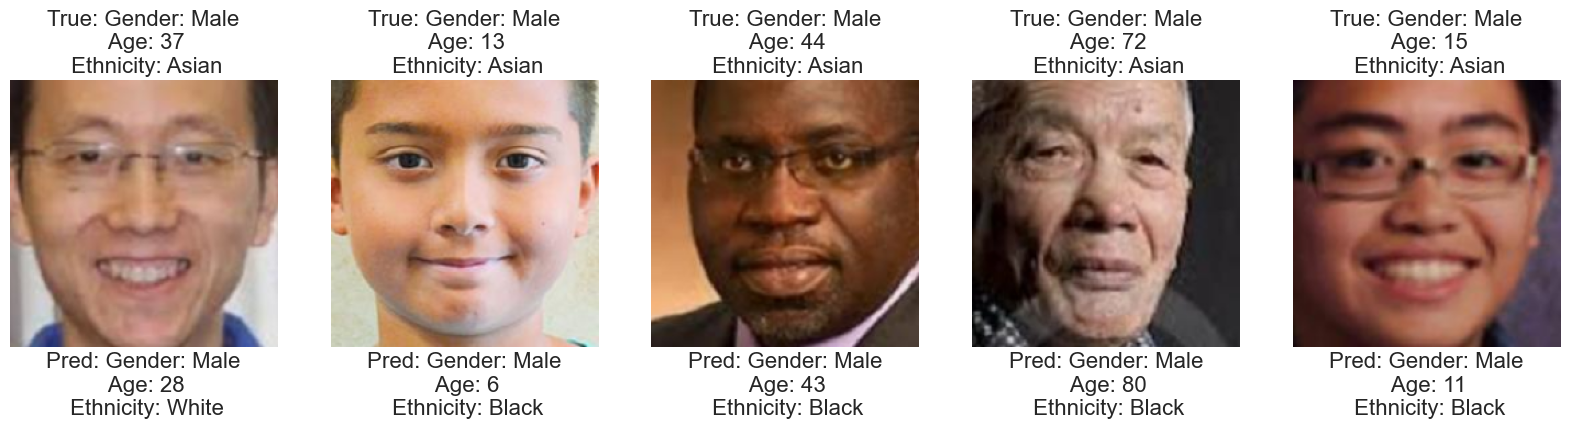

In [136]:
plot_true_pred_labels_asian(model_mn_imba, test_generator)

2/2 [==============================] - 0s 49ms/step


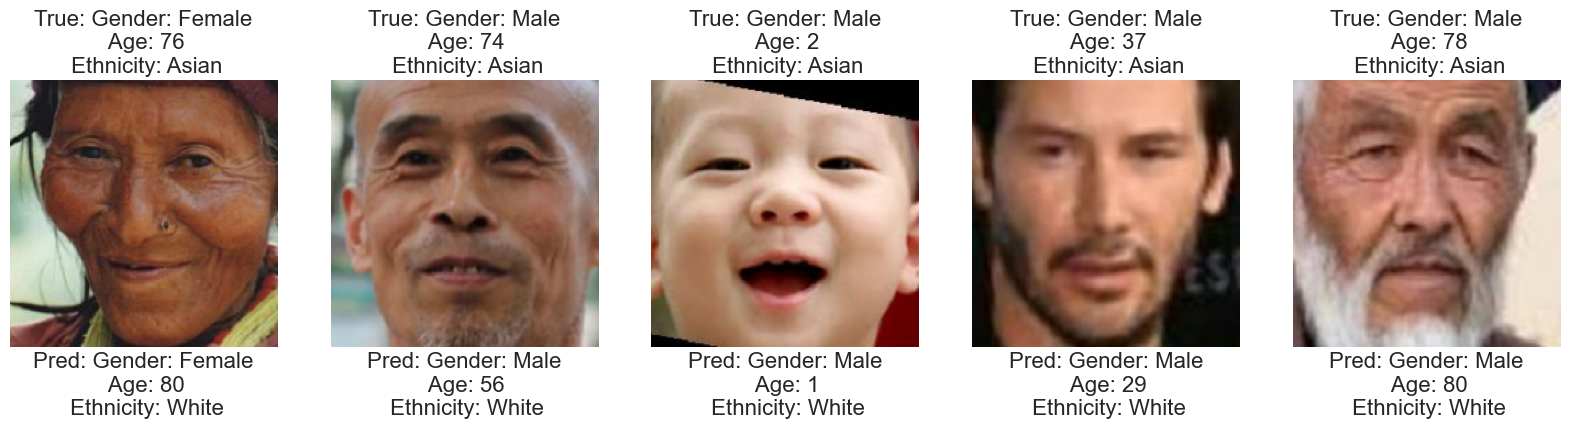

In [144]:
plot_true_pred_labels_asian(model_mn_imba, test_generator)

Nous remarquons qu'il y a des inexactitudes dans la classification de l'origine ethnique. Par exemple, nous pouvons voir sur la première ligne une image qui a été incorrectement étiquetée comme "Asian" alors qu'elle aurait dû être classée comme "Black". De plus, une autre image sur la seconde ligne montre l'acteur Keanu Reeves, dont l'héritage est plus complexe : bien que sa mère soit d'origine chinoise, son père est américain.

### <font color="#114b98"> c) Performances sur la prédiction de l'age</font>

In [121]:
def plot_age_models_mae_box(true_labels_list, pred_labels_list, models):
    bins = list(range(0, np.max(true_labels_list[0][0]) + 10, 10))

    palette = sns.color_palette("rocket_r")
    colors = ['#%02x%02x%02x' % (int(r*255), int(g*255), int(b*255)) for r, g, b in palette]
    if len(models)==2:
        color_dict = {models[0]: colors[0], models[1]: colors[3]}
    else:
        color_dict = dict(zip(models, colors))


    fig, axs = plt.subplots(2, 4, figsize=(20, 12))
    fig.suptitle('Erreur absolue moyenne pour la tranche d\'âge', fontsize=25, y=0.98)

    for i in range(8):
        row = i // 4
        col = i % 4
        ax = axs[row][col]

        data = []
        for j, model in enumerate(models):
            true_labels = true_labels_list[j][0]  
            pred_labels = pred_labels_list[j][0]        
            age_errors = np.abs(true_labels - pred_labels)
            age_error_df = pd.DataFrame({'Age': true_labels, 'Error': age_errors, 'Model': model})
            age_bins = pd.cut(age_error_df['Age'], bins=bins)
            age_error_df['Age'] = age_bins.astype(str)
            age_error_df = age_error_df[(age_error_df['Age'] == str(age_bins.cat.categories[i]))]
            data.append(age_error_df)

        all_data = pd.concat(data)
        boxplot = sns.boxplot(data=all_data, x='Model', y='Error', ax=ax, palette=color_dict, showfliers=False)

        ax.set_xlabel('')
        ax.tick_params(axis='y', labelsize=15)
        ax.set_ylabel('MAE', fontsize=16)
        ax.set_title(f'{bins[i]}-{bins[i+1]}', fontsize=18)
        ax.grid(True)

    plt.tight_layout()
    plt.show()

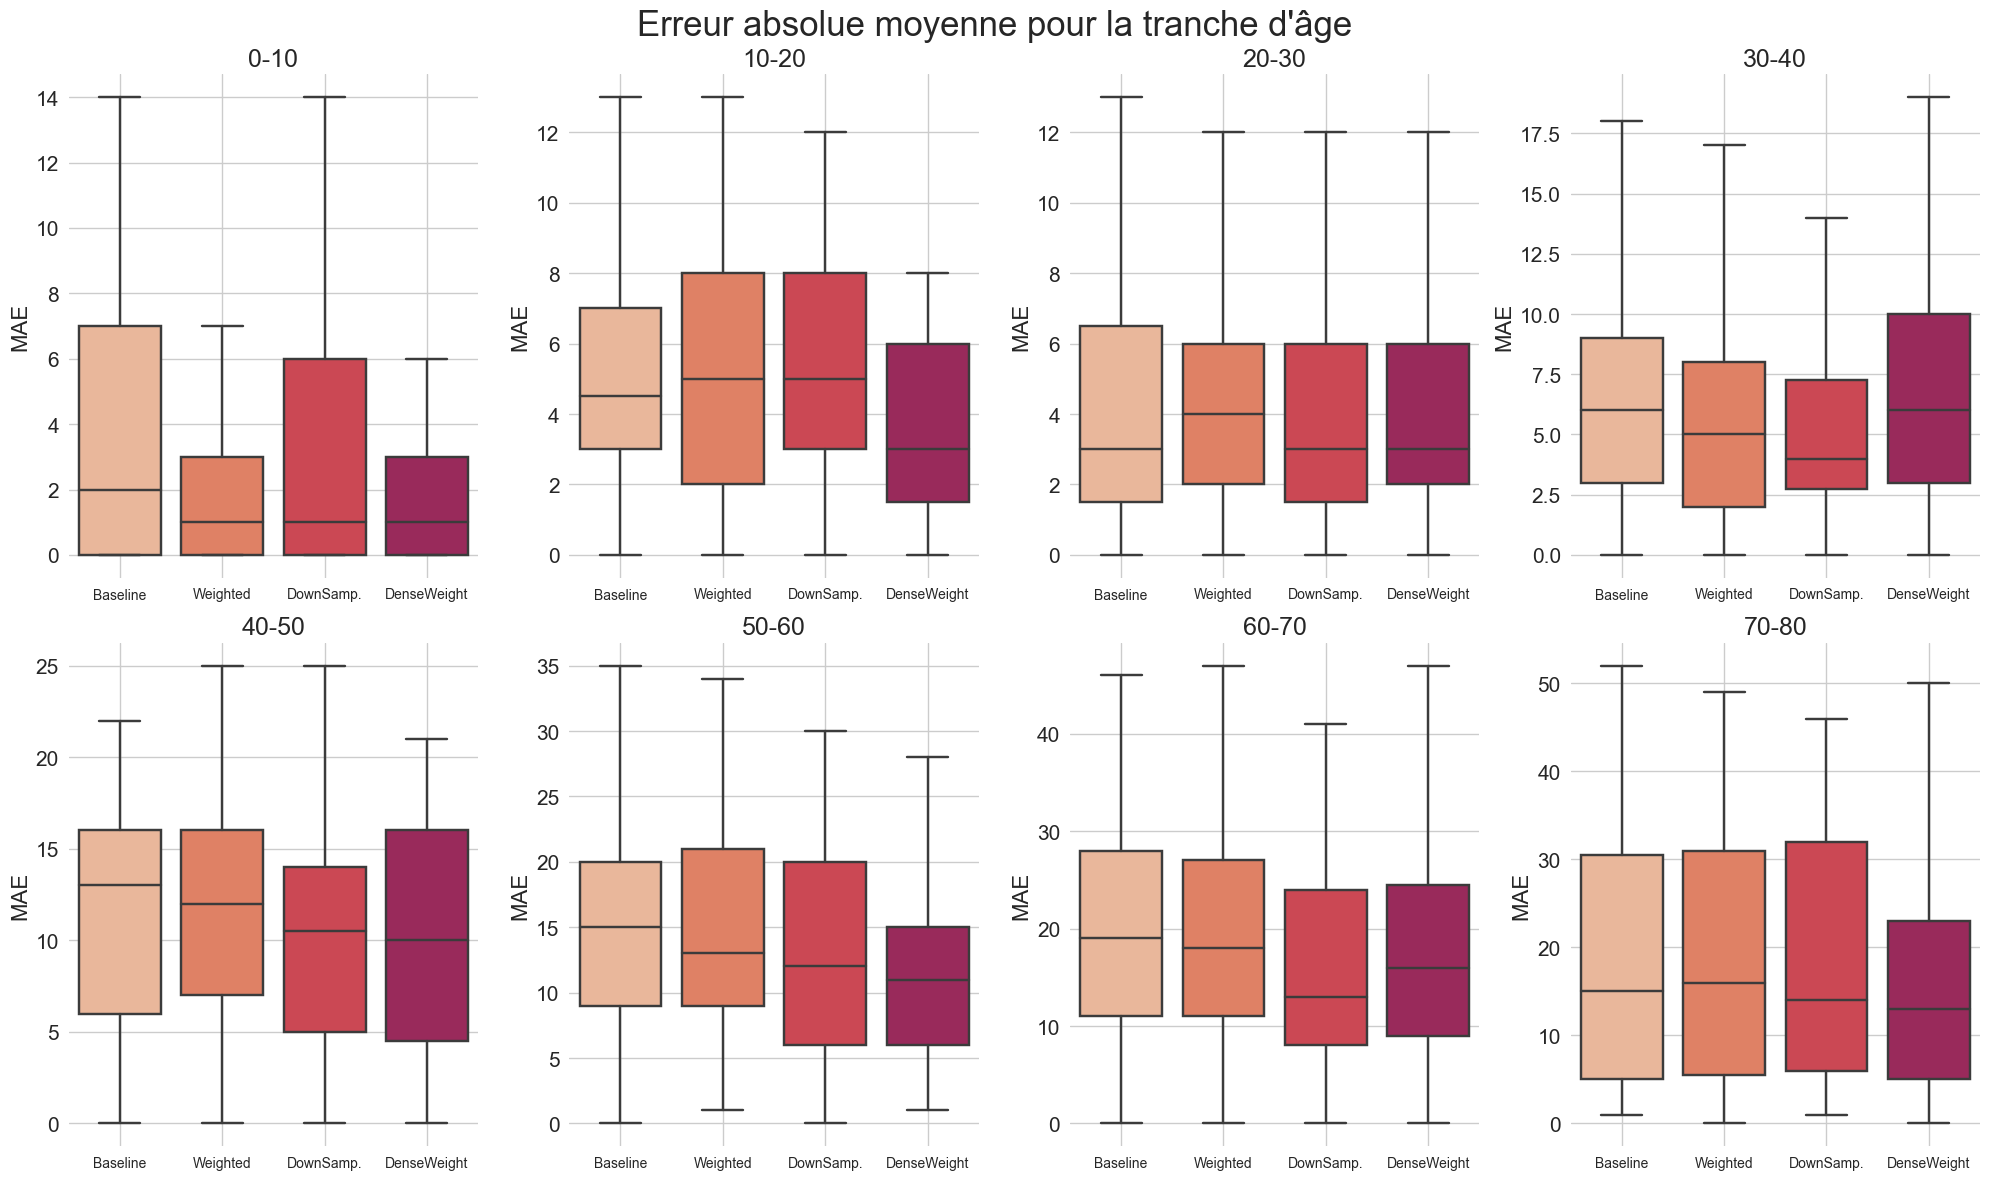

In [122]:
plot_age_models_mae_box([true_labels, true_labels_w, true_labels_us, true_labels_imba], [pred_labels, pred_labels_w, pred_labels_us, pred_labels_imba], ['Baseline', 'Weighted', 'DownSamp.', 'DenseWeight'])

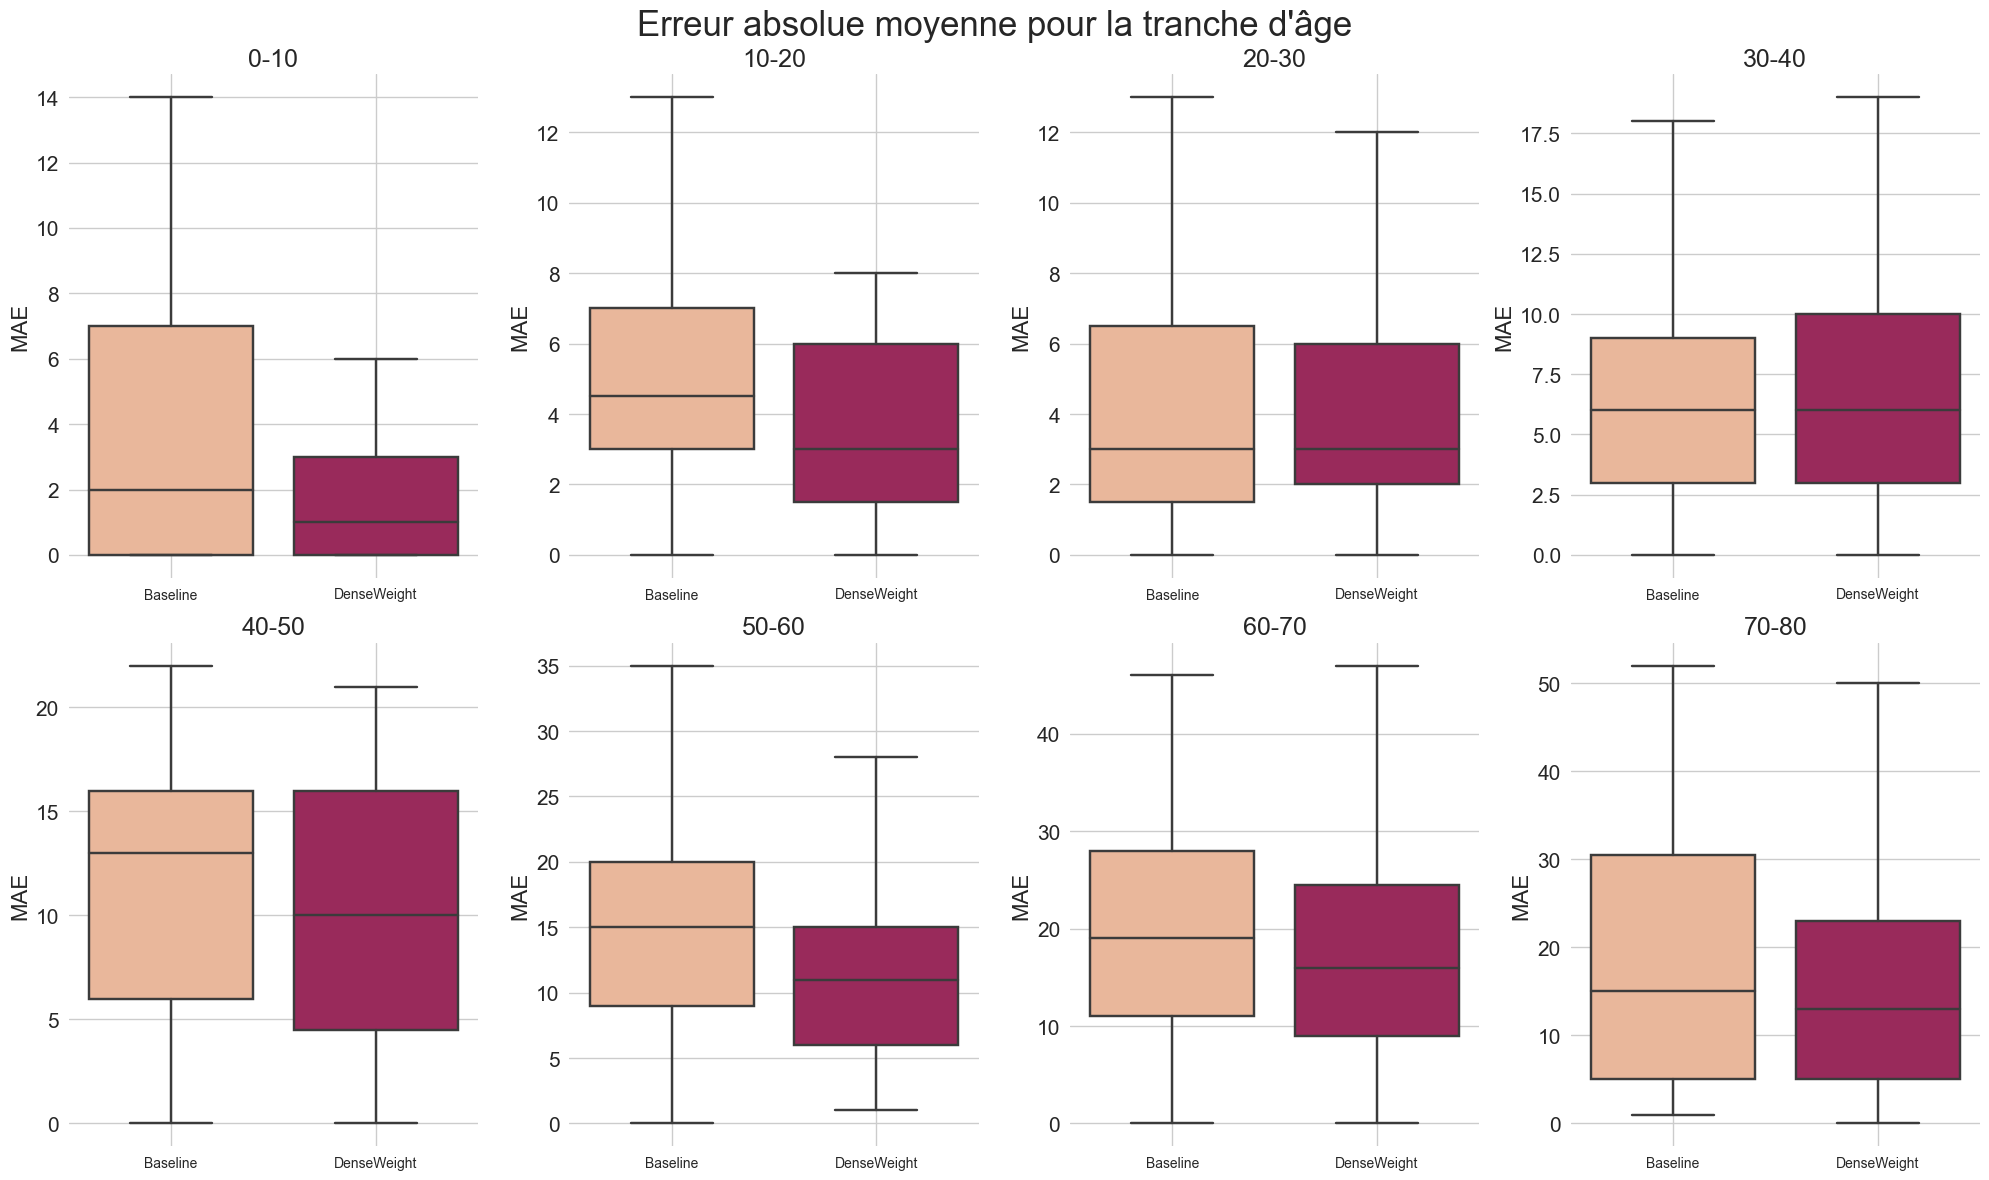

In [123]:
plot_age_models_mae_box([true_labels, true_labels_imba], [pred_labels, pred_labels_imba], ['Baseline', 'DenseWeight'])

L'impact de la méthode DenseWeight a été significatif, entraînant une amélioration notable de 12.8%. Cette méthode a particulièrement bien fonctionné pour les tranches d'âges extrêmes. Elle a permis d'améliorer considérablement la précision des prédictions pour les personnes les plus jeunes, dans la tranche d'âge de 0 à 20 ans, mais aussi pour les personnes âgées de plus de 70 ans. Ainsi, cette approche a démontré une efficacité particulière dans la correction des estimations d'âge aux deux extrémités du spectre.